In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import socket, struct
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import f1_score

pd.set_option('display.max_columns', 500)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
%pip install pyarrow
%pip install fastparquet

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Data exploration and processing

##### Carregamento dos dados

In [52]:
df = pd.read_parquet('subset.gzip')

In [30]:
df_subset = pd.concat([df[df.Label == 0].sample(300000), df[df.Label == 1].sample(300000)])
df_subset.to_parquet('subset.gzip')
df = df_subset

In [21]:
print("This dataset has {} columns and {} rows".format(df.shape[1],df.shape[0]))

This dataset has 25 columns and 600000 rows


##### Describe object (string) columns

In [22]:
df.describe(include=[object])

IPV4_SRC_ADDR IPV4_DST_ADDR SRC_TO_DST_SECOND_BYTES  \
count           600000        600000                  600000   
unique           14063         30619                   40592   
top     10.114.241.166  10.114.226.5                      44   
freq            292272         53779                  293758   

       DST_TO_SRC_SECOND_BYTES  Attack L7_PROTO_NAME PROTOCOL_MAP  
count                   600000  600000        597223       600000  
unique                   39947      19           366            6  
top                         40  Benign       Unknown          tcp  
freq                    254213  300000        346958       437499

##### Describe numerical columns

In [23]:
df.describe()

L4_SRC_PORT    L4_DST_PORT       PROTOCOL      IN_BYTES  \
count  600000.000000  600000.000000  600000.000000  6.000000e+05   
mean    45132.701643   19919.130390       8.441685  8.488199e+03   
std     15054.793373   21873.641367       4.867521  1.370619e+06   
min         0.000000       0.000000       1.000000  4.000000e+00   
25%     48324.000000      80.000000       6.000000  4.400000e+01   
50%     49470.000000    9100.000000       6.000000  4.400000e+01   
75%     49983.000000   39002.000000       6.000000  1.070000e+02   
max     65534.000000   65535.000000     177.000000  6.989114e+08   

             IN_PKTS     OUT_BYTES       OUT_PKTS      TCP_FLAGS  \
count  600000.000000  6.000000e+05  600000.000000  600000.000000   
mean       16.751727  1.937758e+04      17.920853      13.992207   
std      1304.883808  8.827925e+05     661.507983      14.462054   
min         1.000000  0.000000e+00       0.000000       0.000000   
25%         1.000000  4.000000e+01       1.000000       0.000000   
50%         1.000000  4.000000e+01       1.000000      22.000000   
75%         1.000000  1.290000e+02       1.000000      22.000000   
max    648670.000000  3.900007e+08  261644.000000     223.000000   

       FLOW_DURATION_MILLISECONDS  MIN_IP_PKT_LEN  MAX_IP_PKT_LEN  \
count                6.000000e+05   600000.000000   600000.000000   
mean                 4.674960e+04        0.470403        5.322647   
std                  4.345721e+05        5.027152       71.160605   
min                  0.000000e+00        0.000000        0.000000   
25%                  0.000000e+00        0.000000        0.000000   
50%                  0.000000e+00        0.000000        0.000000   
75%                  2.700000e+01        0.000000        0.000000   
max                  4.294966e+06      118.000000     3127.000000   

       RETRANSMITTED_IN_BYTES  RETRANSMITTED_IN_PKTS  RETRANSMITTED_OUT_BYTES  \
count            6.000000e+05          600000.000000             6.000000e+05   
mean             1.800598e+02               0.166870             1.742801e+03   
std              2.194040e+04              15.344579             8.140349e+04   
min              0.000000e+00               0.000000             0.000000e+00   
25%              0.000000e+00               0.000000             0.000000e+00   
50%              0.000000e+00               0.000000             0.000000e+00   
75%              0.000000e+00               0.000000             0.000000e+00   
max              8.081471e+06            5445.000000             3.511003e+07   

       RETRANSMITTED_OUT_PKTS  TCP_WIN_MAX_IN  TCP_WIN_MAX_OUT     Label  
count           600000.000000   600000.000000    600000.000000  600000.0  
mean                 1.225670     6135.611297      3784.267692       0.5  
std                 55.417489    16350.173693     13169.828042       0.5  
min                  0.000000        0.000000         0.000000       0.0  
25%                  0.000000        0.000000         0.000000       0.0  
50%                  0.000000     1024.000000         0.000000       0.5  
75%                  0.000000     1024.000000         0.000000       1.0  
max              23429.000000    65535.000000     65535.000000       1.0

##### Analysis of the number of distinct elements

In [24]:
# Can ignore NaN values
df.nunique()

IPV4_SRC_ADDR                 14063
L4_SRC_PORT                   50213
IPV4_DST_ADDR                 30619
L4_DST_PORT                   65073
PROTOCOL                          6
IN_BYTES                      13143
IN_PKTS                        1529
OUT_BYTES                     14412
OUT_PKTS                       1564
TCP_FLAGS                        38
FLOW_DURATION_MILLISECONDS    25950
MIN_IP_PKT_LEN                   62
MAX_IP_PKT_LEN                  441
SRC_TO_DST_SECOND_BYTES       40592
DST_TO_SRC_SECOND_BYTES       39947
RETRANSMITTED_IN_BYTES          791
RETRANSMITTED_IN_PKTS           153
RETRANSMITTED_OUT_BYTES        1755
RETRANSMITTED_OUT_PKTS          508
TCP_WIN_MAX_IN                 3755
TCP_WIN_MAX_OUT                3838
Label                             2
Attack                           19
L7_PROTO_NAME                   366
PROTOCOL_MAP                      6
dtype: int64

##### Checking if the dataset has duplicate rows

In [25]:
df.duplicated().sum()

14257

##### Analysis of columns with null values

In [26]:
print("Total de valores nulos")
print(df.isnull().sum())

Total de valores nulos
IPV4_SRC_ADDR                    0
L4_SRC_PORT                      0
IPV4_DST_ADDR                    0
L4_DST_PORT                      0
PROTOCOL                         0
IN_BYTES                         0
IN_PKTS                          0
OUT_BYTES                        0
OUT_PKTS                         0
TCP_FLAGS                        0
FLOW_DURATION_MILLISECONDS       0
MIN_IP_PKT_LEN                   0
MAX_IP_PKT_LEN                   0
SRC_TO_DST_SECOND_BYTES          0
DST_TO_SRC_SECOND_BYTES          0
RETRANSMITTED_IN_BYTES           0
RETRANSMITTED_IN_PKTS            0
RETRANSMITTED_OUT_BYTES          0
RETRANSMITTED_OUT_PKTS           0
TCP_WIN_MAX_IN                   0
TCP_WIN_MAX_OUT                  0
Label                            0
Attack                           0
L7_PROTO_NAME                 2777
PROTOCOL_MAP                     0
dtype: int64


##### Distribution of the categorical variables

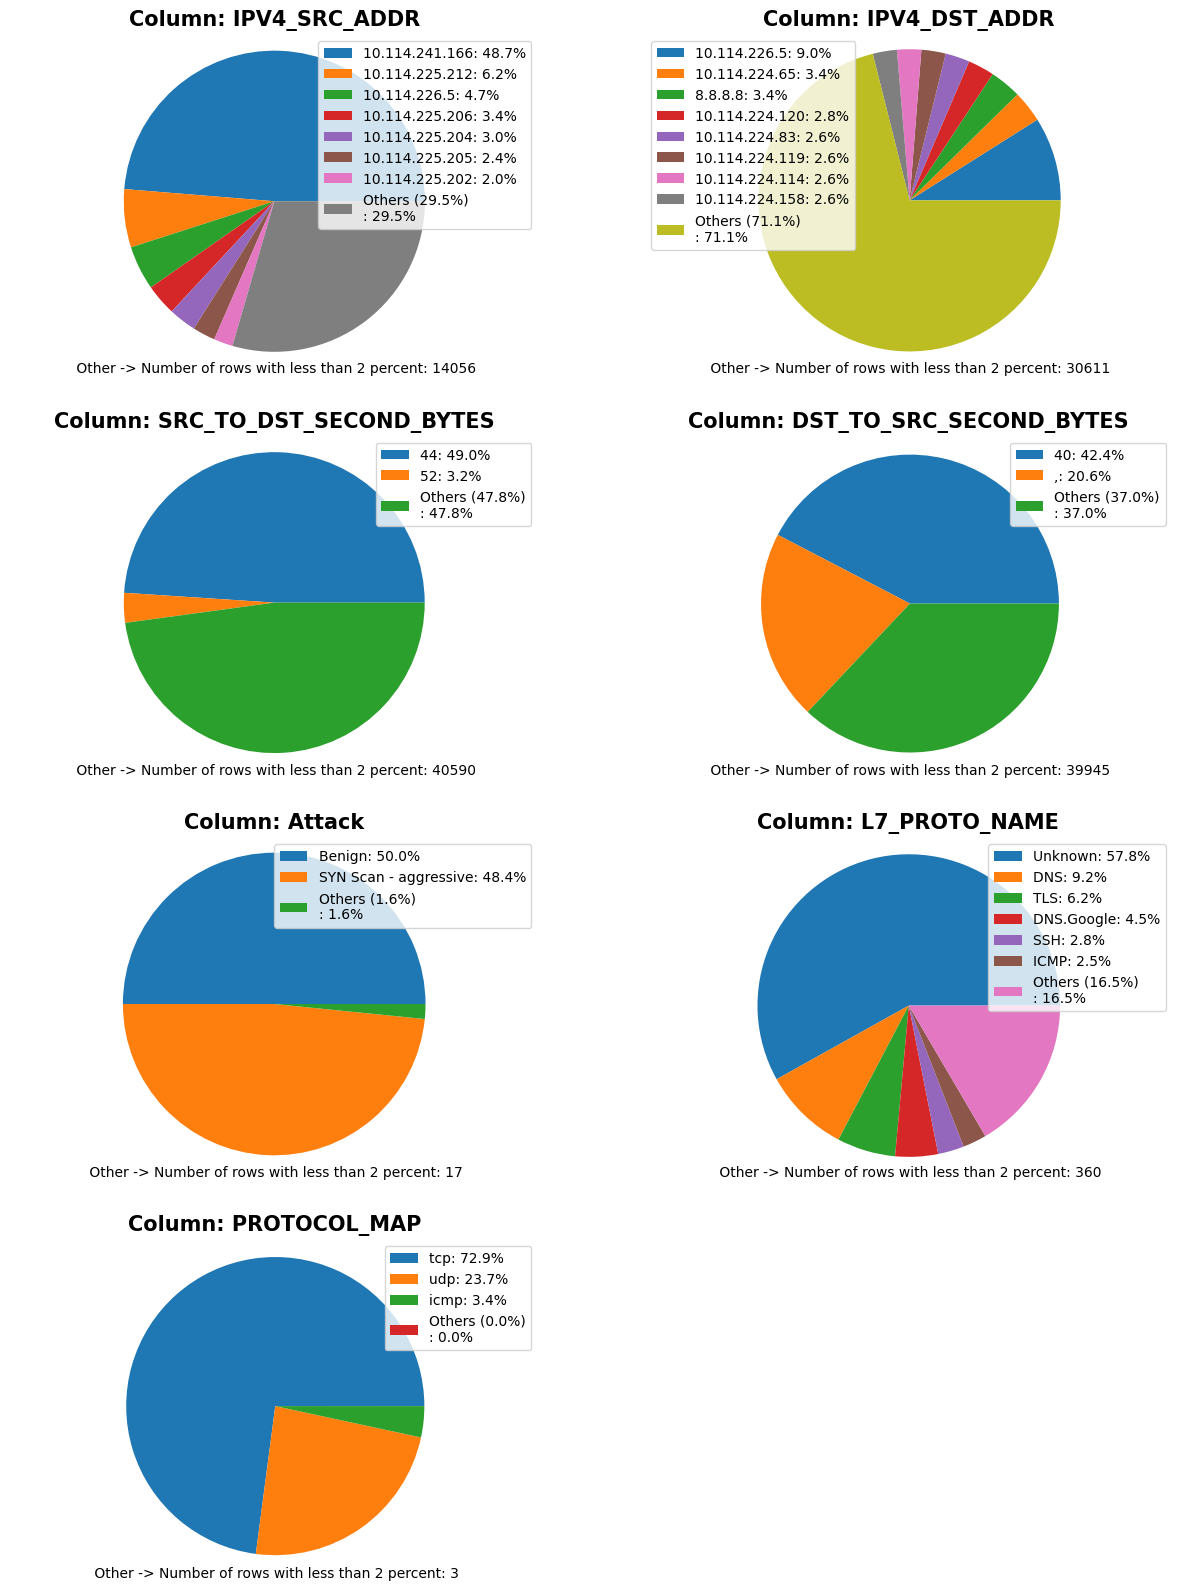

In [27]:
cols = ["IPV4_SRC_ADDR", "IPV4_DST_ADDR", "SRC_TO_DST_SECOND_BYTES", "DST_TO_SRC_SECOND_BYTES", "Attack", "L7_PROTO_NAME", "PROTOCOL_MAP"]
fig_nr_columns = 2
fig_nr_rows = 4
fig = plt.figure(1, figsize=[15,20])
percentage = 2

for k in range(len(cols)):
    value_counts = df[cols[k]].value_counts()
    percentage_values = (value_counts / len(df)) * 100
    filtered_values = percentage_values[percentage_values > percentage]
    filtered_values_others = percentage_values[percentage_values <= percentage]
    filtered_values_others_sum = filtered_values_others.sum()
    others_series = pd.Series({f'Others ({filtered_values_others_sum:.1f}%)\n': filtered_values_others_sum})
    filtered_values = pd.concat([filtered_values, others_series])
    labels = filtered_values.index
    sizes = filtered_values.values
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    ax.pie(sizes, labels=None, autopct=None)
    plt.axis('equal')
    plt.title("Column: {}".format(cols[k]), fontweight='bold', fontsize=15)
    legend_labels = [f'{label}: {size:.1f}%' for label, size in zip(labels, sizes)]
    plt.legend(legend_labels, loc='best')
    count_less_than_two_percent = len(filtered_values_others)
    plt.annotate(f' Other -> Number of rows with less than {percentage} percent: {count_less_than_two_percent}', xy=(0.5, 0.0), xycoords='axes fraction',ha='center', va='center')
    
plt.show()

In [28]:
cols = ["IPV4_SRC_ADDR","IPV4_DST_ADDR","SRC_TO_DST_SECOND_BYTES","DST_TO_SRC_SECOND_BYTES","Attack","L7_PROTO_NAME","PROTOCOL_MAP"]

for k in range(len(cols)):
    print("Column: ",cols[k])
    value_counts = df[cols[k]].value_counts()
    percentage_values = (value_counts / len(df)) * 100
    filtered_values = percentage_values[percentage_values > 2]
    for value, percentage in filtered_values.items():
        print(f'    {value}: {percentage:.1f}%')
    count_less_than_two_percent = len(percentage_values[percentage_values <= 1])
    print(f'    Number of rows with less than two percent: {count_less_than_two_percent}')

Column:  IPV4_SRC_ADDR
    10.114.241.166: 48.7%
    10.114.225.212: 6.2%
    10.114.226.5: 4.7%
    10.114.225.206: 3.4%
    10.114.225.204: 3.0%
    10.114.225.205: 2.4%
    10.114.225.202: 2.0%
    Number of rows with less than two percent: 14050
Column:  IPV4_DST_ADDR
    10.114.226.5: 9.0%
    10.114.224.65: 3.4%
    8.8.8.8: 3.4%
    10.114.224.120: 2.8%
    10.114.224.83: 2.6%
    10.114.224.119: 2.6%
    10.114.224.114: 2.6%
    10.114.224.158: 2.6%
    Number of rows with less than two percent: 30583
Column:  SRC_TO_DST_SECOND_BYTES
    44: 49.0%
    52: 3.2%
    Number of rows with less than two percent: 40584
Column:  DST_TO_SRC_SECOND_BYTES
    40: 42.4%
    ,: 20.6%
    Number of rows with less than two percent: 39943
Column:  Attack
    Benign: 50.0%
    SYN Scan - aggressive: 48.4%
    Number of rows with less than two percent: 17
Column:  L7_PROTO_NAME
    Unknown: 57.8%
    DNS: 9.2%
    TLS: 6.2%
    DNS.Google: 4.5%
    SSH: 2.8%
    ICMP: 2.5%
    Number of rows wit

##### Distribution of the numerical variances

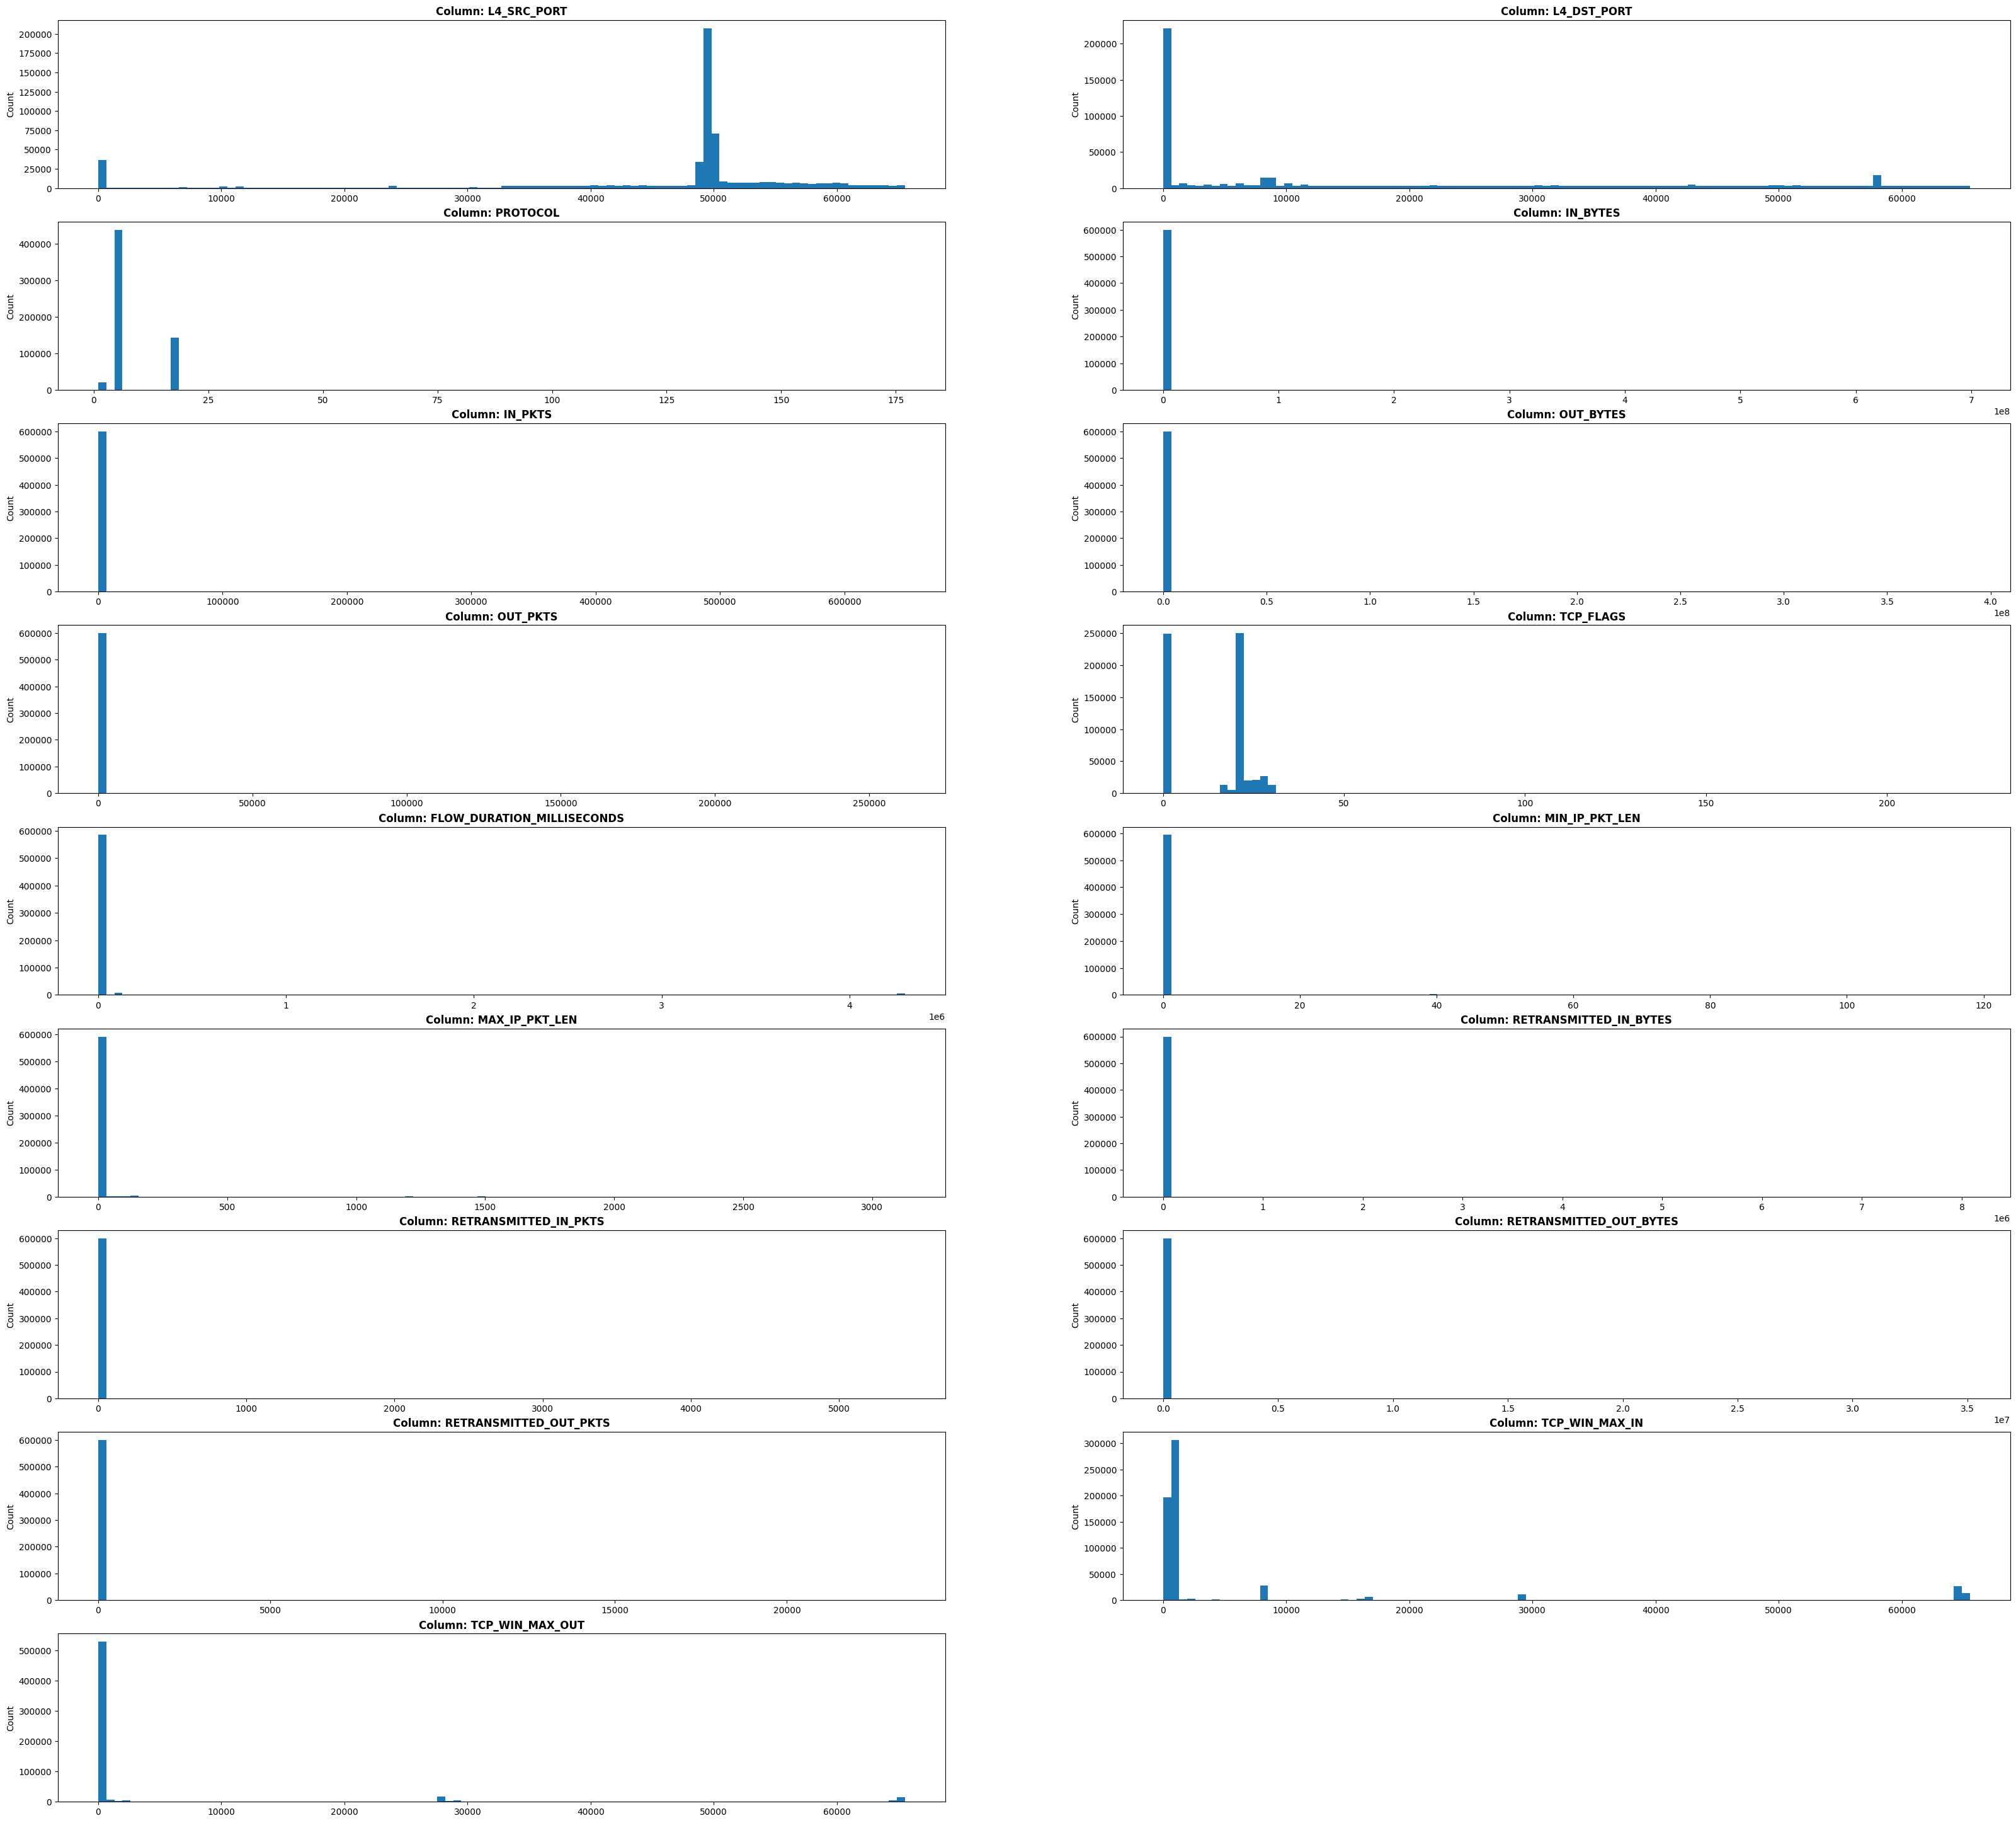

In [29]:
cols = ["L4_SRC_PORT","L4_DST_PORT","PROTOCOL","IN_BYTES","IN_PKTS","OUT_BYTES","OUT_PKTS","TCP_FLAGS","FLOW_DURATION_MILLISECONDS","MIN_IP_PKT_LEN","MAX_IP_PKT_LEN","RETRANSMITTED_IN_BYTES","RETRANSMITTED_IN_PKTS","RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS","TCP_WIN_MAX_IN","TCP_WIN_MAX_OUT"]

fig_nr_columns = 2
fig_nr_rows = 17
fig = plt.figure(1, figsize=[40,70])

for k in range(len(cols)):
    num_bins = 100
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    ax.hist(df[cols[k]], num_bins)
    plt.title("Column: {}".format(cols[k]), fontweight='bold')
    plt.ylabel("Count")

plt.show()

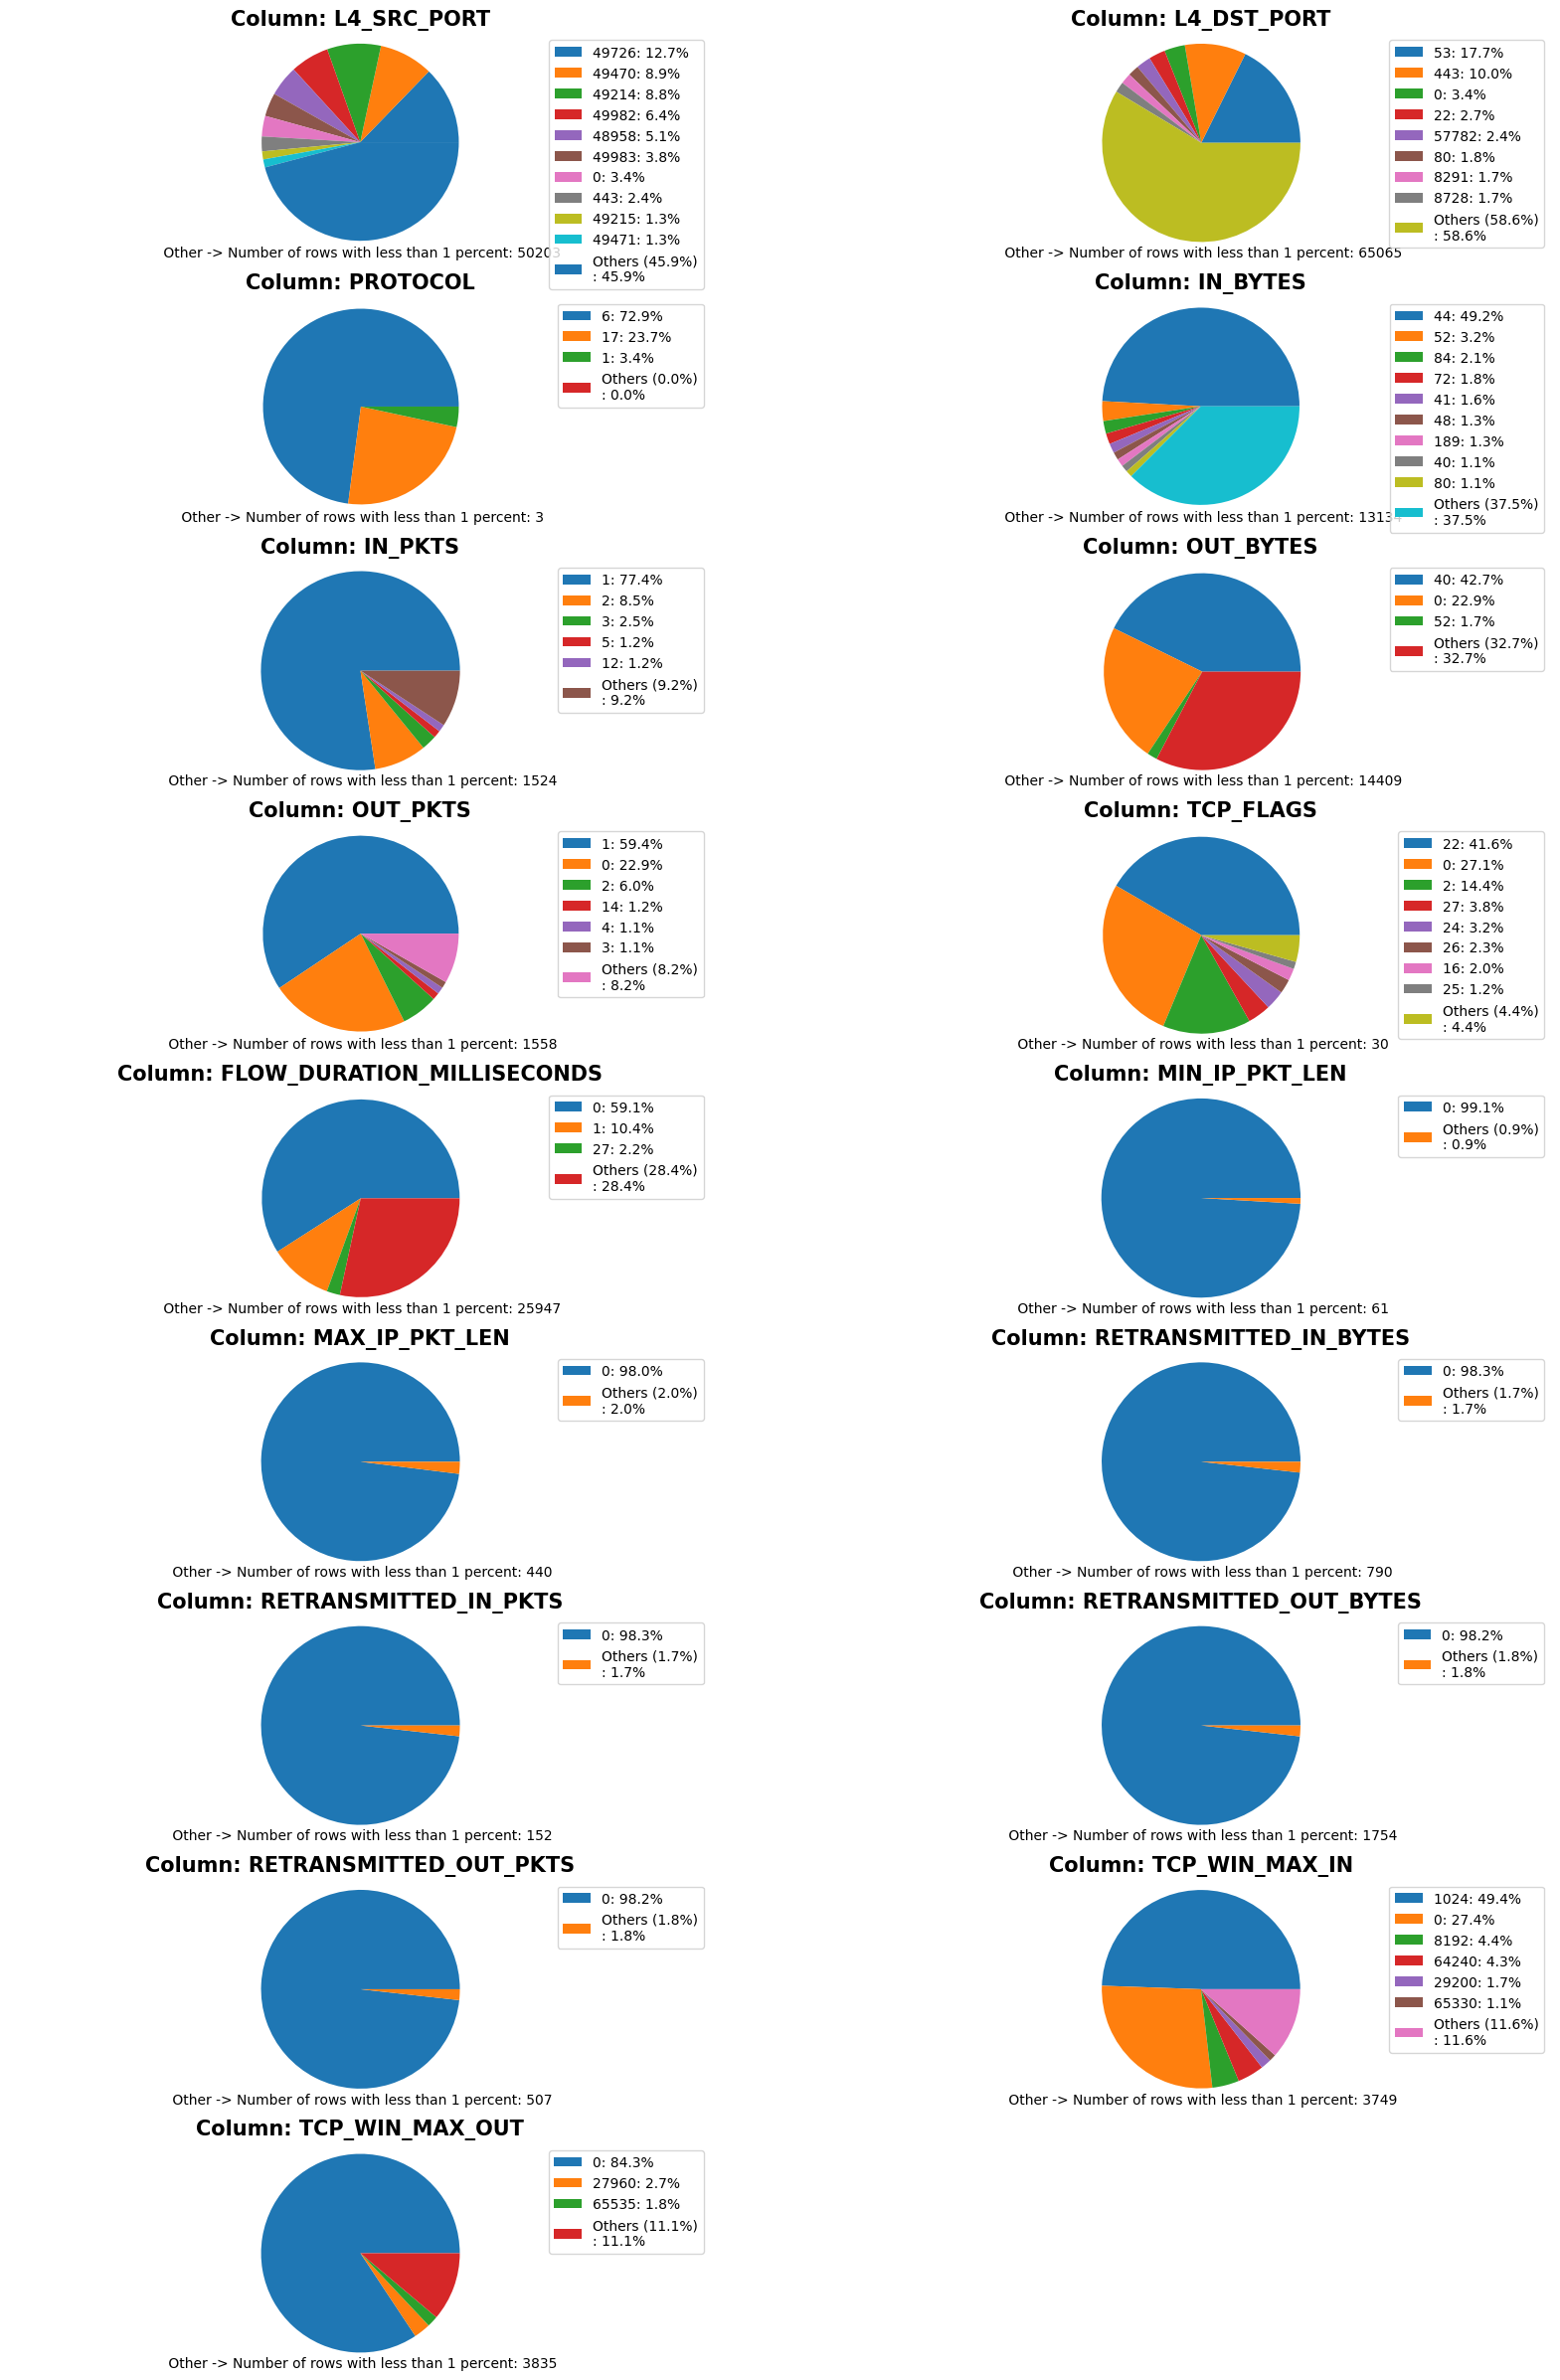

In [30]:
cols = ["L4_SRC_PORT","L4_DST_PORT","PROTOCOL","IN_BYTES","IN_PKTS","OUT_BYTES","OUT_PKTS","TCP_FLAGS","FLOW_DURATION_MILLISECONDS","MIN_IP_PKT_LEN","MAX_IP_PKT_LEN","RETRANSMITTED_IN_BYTES","RETRANSMITTED_IN_PKTS","RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS","TCP_WIN_MAX_IN","TCP_WIN_MAX_OUT"]
fig_nr_columns = 2
fig_nr_rows = 17
fig = plt.figure(1, figsize=[20,58])
percentage = 1

for k in range(len(cols)):
    value_counts = df[cols[k]].value_counts()
    percentage_values = (value_counts / len(df)) * 100
    filtered_values = percentage_values[percentage_values > percentage]
    filtered_values_others = percentage_values[percentage_values <= percentage]
    filtered_values_others_sum = filtered_values_others.sum()
    others_series = pd.Series({f'Others ({filtered_values_others_sum:.1f}%)\n': filtered_values_others_sum})
    filtered_values = pd.concat([filtered_values, others_series])
    labels = filtered_values.index
    sizes = filtered_values.values
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    ax.pie(sizes, labels=None, autopct=None)
    plt.axis('equal')
    plt.title("Column: {}".format(cols[k]), fontweight='bold', fontsize=15)
    legend_labels = [f'{label}: {size:.1f}%' for label, size in zip(labels, sizes)]
    plt.legend(legend_labels, loc='best')
    count_less_than_two_percent = len(filtered_values_others)
    plt.annotate(f' Other -> Number of rows with less than {percentage} percent: {count_less_than_two_percent}', xy=(0.5, 0.0), xycoords='axes fraction',ha='center', va='center')
    
plt.show()

##### Convert IPs to numbers

In [51]:
def ip2long(ip):
    """
    Convert an IP string to long
    """
    ip = '.'.join(ip.split('.')[:-1] + ['0'])
    packedIP = socket.inet_aton(ip)
    return struct.unpack("!L", packedIP)[0]

df.loc[:,'IPV4_SRC_ADDR'] = df['IPV4_SRC_ADDR'].copy().apply(ip2long)
df.loc[:,'IPV4_DST_ADDR'] = df['IPV4_DST_ADDR'].copy().apply(ip2long)
df.head(2)

IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  \
1191744     2148454656        46482      175300864         5060        17   
625489       175300864        46626      804663296          443         6   

         IN_BYTES  IN_PKTS  OUT_BYTES  OUT_PKTS  TCP_FLAGS  \
1191744       414        1          0         0          0   
625489       7589      130     178738       131         26   

         FLOW_DURATION_MILLISECONDS  MIN_IP_PKT_LEN  MAX_IP_PKT_LEN  \
1191744                           0               0               0   
625489                          882               0               0   

        SRC_TO_DST_SECOND_BYTES DST_TO_SRC_SECOND_BYTES  \
1191744                     414                       ,   
625489                4829,2760             89913,88825   

         RETRANSMITTED_IN_BYTES  RETRANSMITTED_IN_PKTS  \
1191744                       0                      0   
625489                     1460                      1   

         RETRANSMITTED_OUT_BYTES  RETRANSMITTED_OUT_PKTS  TCP_WIN_MAX_IN  \
1191744                        0                       0               0   
625489                       419                       2           65535   

         TCP_WIN_MAX_OUT  Label  Attack L7_PROTO_NAME PROTOCOL_MAP  
1191744                0      0  Benign           SIP          udp  
625489             29200      0  Benign           TLS          tcp

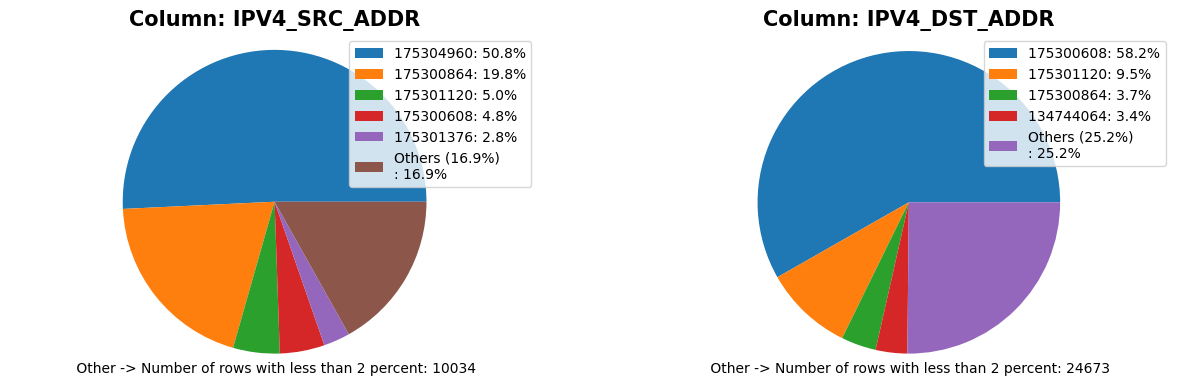

In [4]:
cols = ["IPV4_SRC_ADDR", "IPV4_DST_ADDR"]
fig_nr_columns = 2
fig_nr_rows = 4
fig = plt.figure(1, figsize=[15,20])
percentage = 2

for k in range(len(cols)):
    value_counts = df[cols[k]].value_counts()
    percentage_values = (value_counts / len(df)) * 100
    filtered_values = percentage_values[percentage_values > percentage]
    filtered_values_others = percentage_values[percentage_values <= percentage]
    filtered_values_others_sum = filtered_values_others.sum()
    others_series = pd.Series({f'Others ({filtered_values_others_sum:.1f}%)\n': filtered_values_others_sum})
    filtered_values = pd.concat([filtered_values, others_series])
    labels = filtered_values.index
    sizes = filtered_values.values
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    ax.pie(sizes, labels=None, autopct=None)
    plt.axis('equal')
    plt.title("Column: {}".format(cols[k]), fontweight='bold', fontsize=15)
    legend_labels = [f'{label}: {size:.1f}%' for label, size in zip(labels, sizes)]
    plt.legend(legend_labels, loc='best')
    count_less_than_two_percent = len(filtered_values_others)
    plt.annotate(f' Other -> Number of rows with less than {percentage} percent: {count_less_than_two_percent}', xy=(0.5, 0.0), xycoords='axes fraction',ha='center', va='center')
    
plt.show()

##### Remove rows with NaN Labels

In [21]:
df = df[df['L7_PROTO_NAME'].notna()]
len(df[df.Label == 0]), len(df[df.Label == 1]), df.Label.isna().sum()

(299983, 297207, 0)

In [22]:
def spb_to_mean(x):
    vals = x.split(',')
    vals = list(filter(lambda v: v != '', vals))
    vals = [int(float(x)) for x in vals]
    
    if len(vals) == 0: return 0
    
    return np.asarray(vals, dtype=np.float64).mean()

def spb_to_total(x):
    vals = x.split(',')
    vals = list(filter(lambda v: v != '', vals))
    vals = [int(float(x)) for x in vals]
    
    return np.asarray(vals, dtype=np.float64).sum()

df['DST_TO_SRC_SECOND_BYTES_MEAN'] = df.DST_TO_SRC_SECOND_BYTES.apply(spb_to_mean)
df['DST_TO_SRC_SECOND_BYTES_TOTAL'] = df.DST_TO_SRC_SECOND_BYTES.apply(spb_to_total)
df['SRC_TO_DST_SECOND_BYTES_MEAN'] = df.SRC_TO_DST_SECOND_BYTES.apply(spb_to_mean)
df['SRC_TO_DST_SECOND_BYTES_TOTAL'] = df.SRC_TO_DST_SECOND_BYTES.apply(spb_to_total)

##### Label Encoding da feature L7_PROTO_NAME

In [23]:
l7_proto_encoder = LabelEncoder()
df['L7_PROTO_NAME'] = l7_proto_encoder.fit_transform(df['L7_PROTO_NAME'])

##### Label Encoding da feature AttackEnc

In [24]:
attack_encoder = LabelEncoder()
df['AttackEnc'] = attack_encoder.fit_transform(df.Attack)

##### Remove features 

In [25]:
df = df.drop(['DST_TO_SRC_SECOND_BYTES', 'SRC_TO_DST_SECOND_BYTES'], axis=1)

##### Calculates the standard deviation of the values in column DST_TO_SRC_SECOND_BYTES_MEAN

In [38]:
np.array(df.DST_TO_SRC_SECOND_BYTES_MEAN).std()

21684586533.038044

In [39]:
df.columns

Index(['IPV4_SRC_ADDR', 'L4_SRC_PORT', 'IPV4_DST_ADDR', 'L4_DST_PORT',
       'PROTOCOL', 'IN_BYTES', 'IN_PKTS', 'OUT_BYTES', 'OUT_PKTS', 'TCP_FLAGS',
       'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN', 'MAX_IP_PKT_LEN',
       'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS', 'TCP_WIN_MAX_IN',
       'TCP_WIN_MAX_OUT', 'Label', 'Attack', 'L7_PROTO_NAME', 'PROTOCOL_MAP',
       'DST_TO_SRC_SECOND_BYTES_MEAN', 'DST_TO_SRC_SECOND_BYTES_TOTAL',
       'SRC_TO_DST_SECOND_BYTES_MEAN', 'SRC_TO_DST_SECOND_BYTES_TOTAL',
       'AttackEnc'],
      dtype='object')

#### Bin creation

In [59]:
bins = [
    { 'col': 'IN_BYTES', 'n_bins': 4 },
    { 'col': 'OUT_BYTES', 'n_bins': 4 },
    { 'col': 'IN_PKTS', 'n_bins': 4 },
    { 'col': 'OUT_PKTS', 'n_bins': 4 },
    { 'col': 'FLOW_DURATION_MILLISECONDS', 'n_bins': 4 },
    { 'col': 'MAX_IP_PKT_LEN', 'n_bins': 4 },
    { 'col': 'MIN_IP_PKT_LEN', 'n_bins': 4 },
    { 'col': 'RETRANSMITTED_IN_BYTES', 'n_bins': 4 },
    { 'col': 'RETRANSMITTED_IN_PKTS', 'n_bins': 4 },
    { 'col': 'RETRANSMITTED_OUT_BYTES', 'n_bins': 4 },
    { 'col': 'RETRANSMITTED_OUT_PKTS', 'n_bins': 4 },
    { 'col': 'DST_TO_SRC_SECOND_BYTES_MEAN', 'n_bins': 4 },
    { 'col': 'DST_TO_SRC_SECOND_BYTES_TOTAL', 'n_bins': 4 },
    { 'col': 'SRC_TO_DST_SECOND_BYTES_MEAN', 'n_bins': 4 },
    { 'col': 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'n_bins': 4 },
    { 'col': 'TCP_WIN_MAX_IN', 'n_bins': 4 },
    { 'col': 'TCP_WIN_MAX_OUT', 'n_bins': 4 },
]

cols = [ x['col'] for x in bins ]

enc = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform')
df[cols] = enc.fit_transform(df[cols])
#bin_['enc'] = enc
# for bin_ in bins:
#     enc = KBinsDiscretizer(n_bins=bin_['n_bins'], encode='ordinal', strategy='uniform')
#     df[bin_['col']] = enc.fit_transform(df[bin_['col']])
#     bin_['enc'] = enc

##### Correlation matrix

<AxesSubplot:>

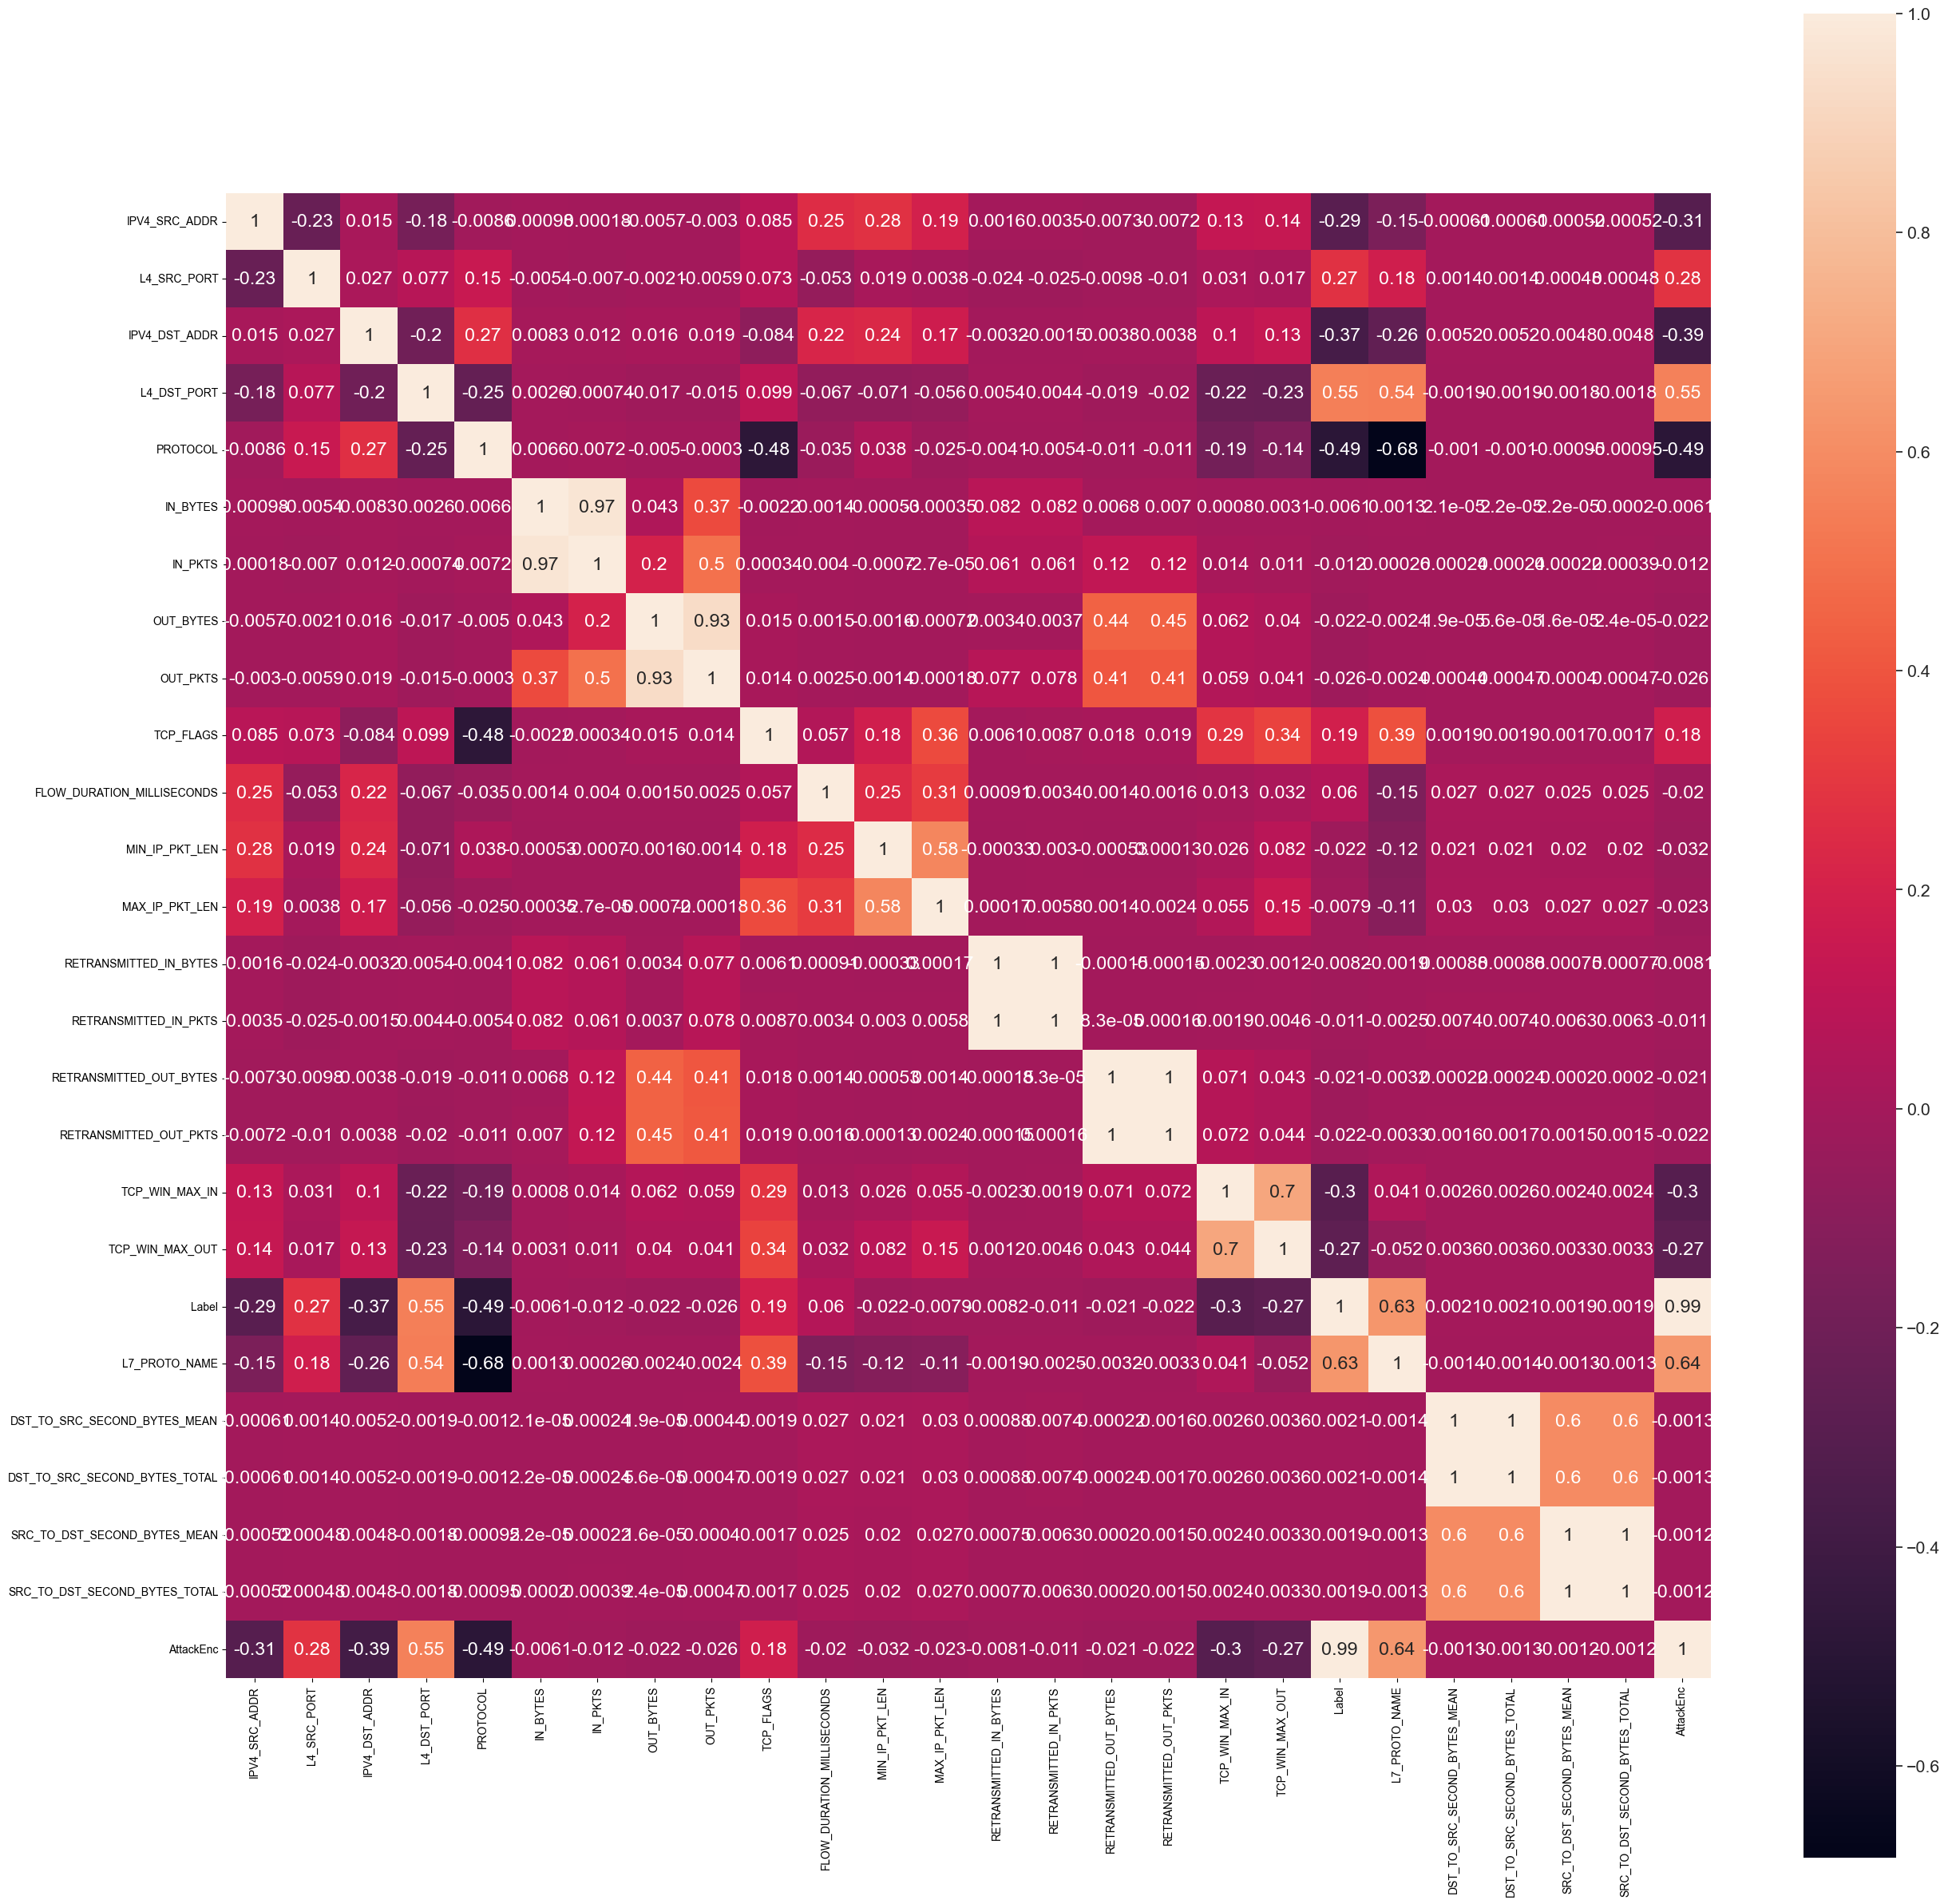

In [10]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(30, 30))
#plt.legend(title='Correlation Matrix', fontsize=20)
sns.set(font_scale=1.4)
sns.heatmap(corr, square=True, ax=ax, annot=True)

<AxesSubplot:xlabel='TCP_WIN_MAX_IN', ylabel='TCP_WIN_MAX_OUT'>

/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


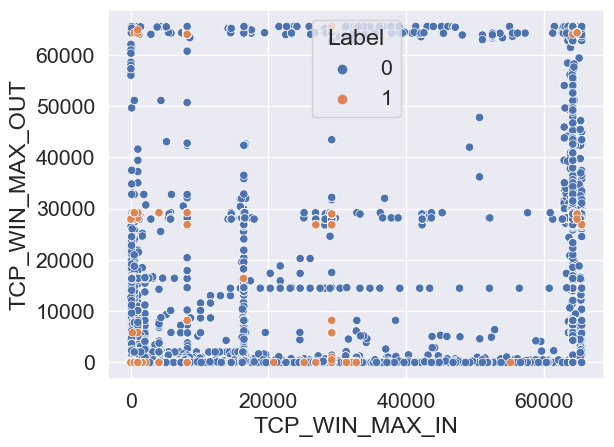

In [31]:
sns.scatterplot(data=df, x="TCP_WIN_MAX_IN", y="TCP_WIN_MAX_OUT", hue="Label")

<AxesSubplot:xlabel='TCP_WIN_MAX_IN', ylabel='IN_BYTES'>

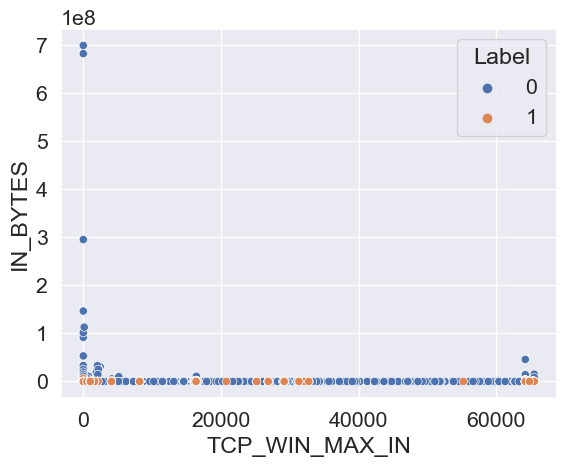

In [32]:
sns.scatterplot(data=df, x="TCP_WIN_MAX_IN", y="IN_BYTES", hue="Label")

<AxesSubplot:xlabel='IPV4_SRC_ADDR', ylabel='L4_DST_PORT'>

/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


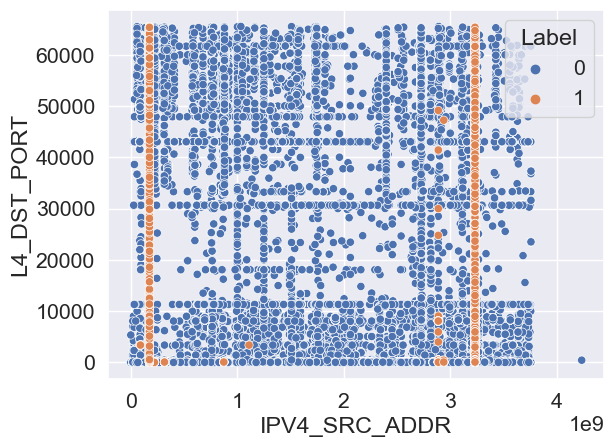

In [9]:
sns.scatterplot(data=df, x="IPV4_SRC_ADDR", y="L4_DST_PORT", hue="Label")

<AxesSubplot:xlabel='IPV4_DST_ADDR', ylabel='L4_DST_PORT'>

/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


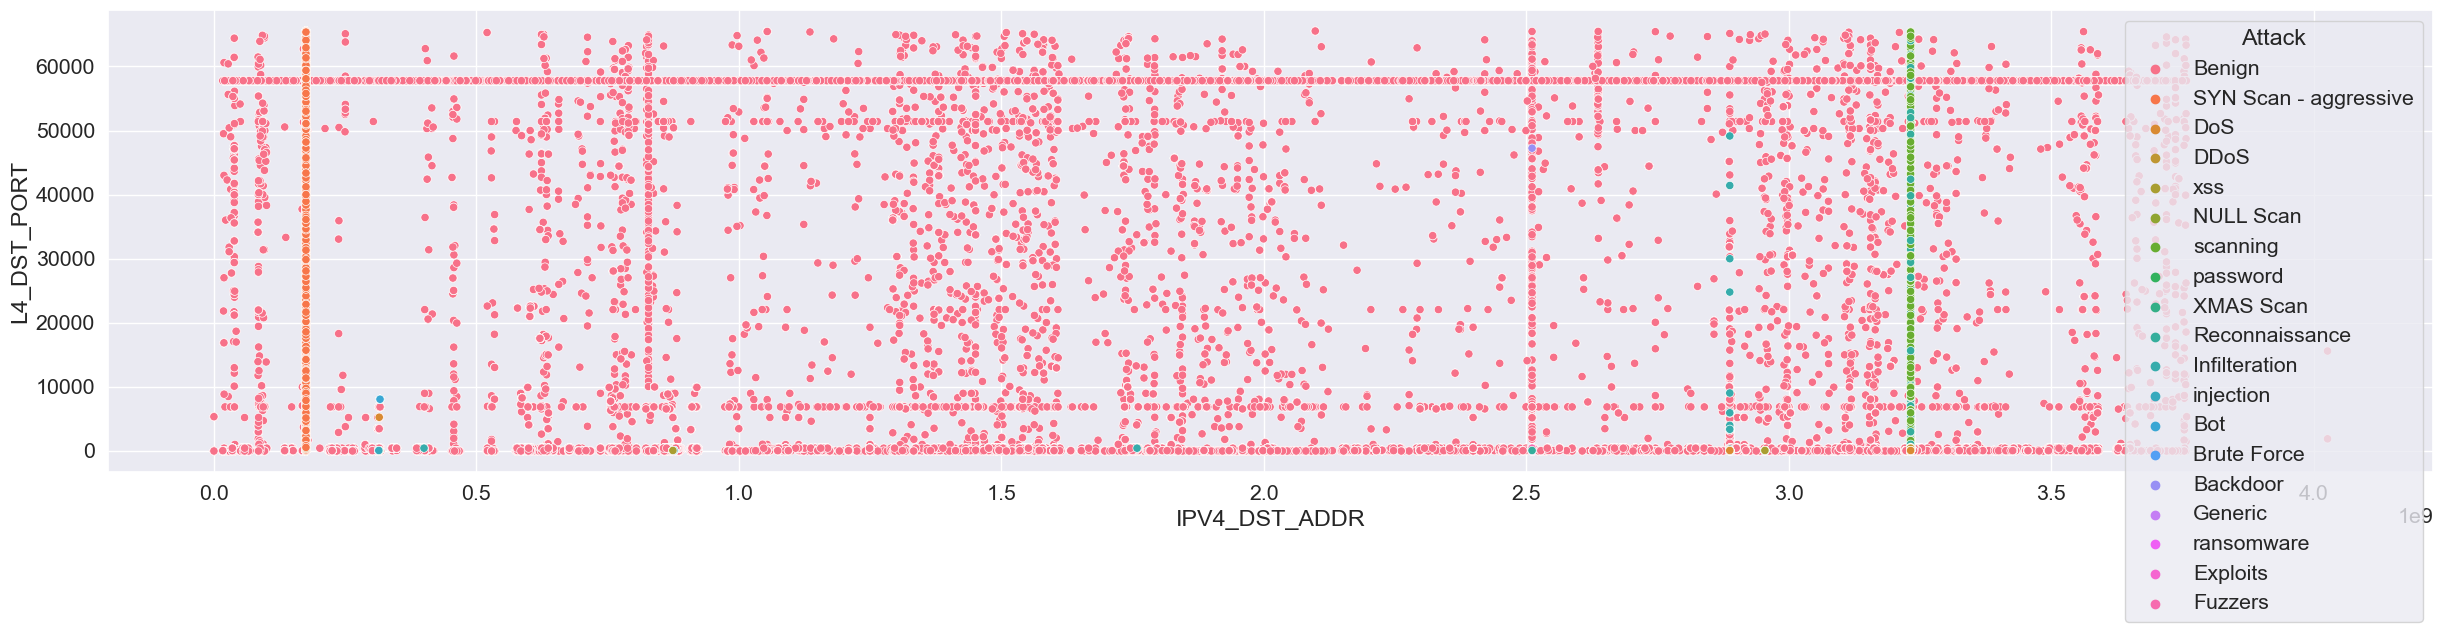

In [13]:
fig, ax = plt.subplots(figsize=(30, 6))
sns.scatterplot(data=df, x="IPV4_DST_ADDR", y="L4_DST_PORT", hue="Attack", ax=ax)



<AxesSubplot:xlabel='IPV4_DST_ADDR', ylabel='L4_SRC_PORT'>

/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


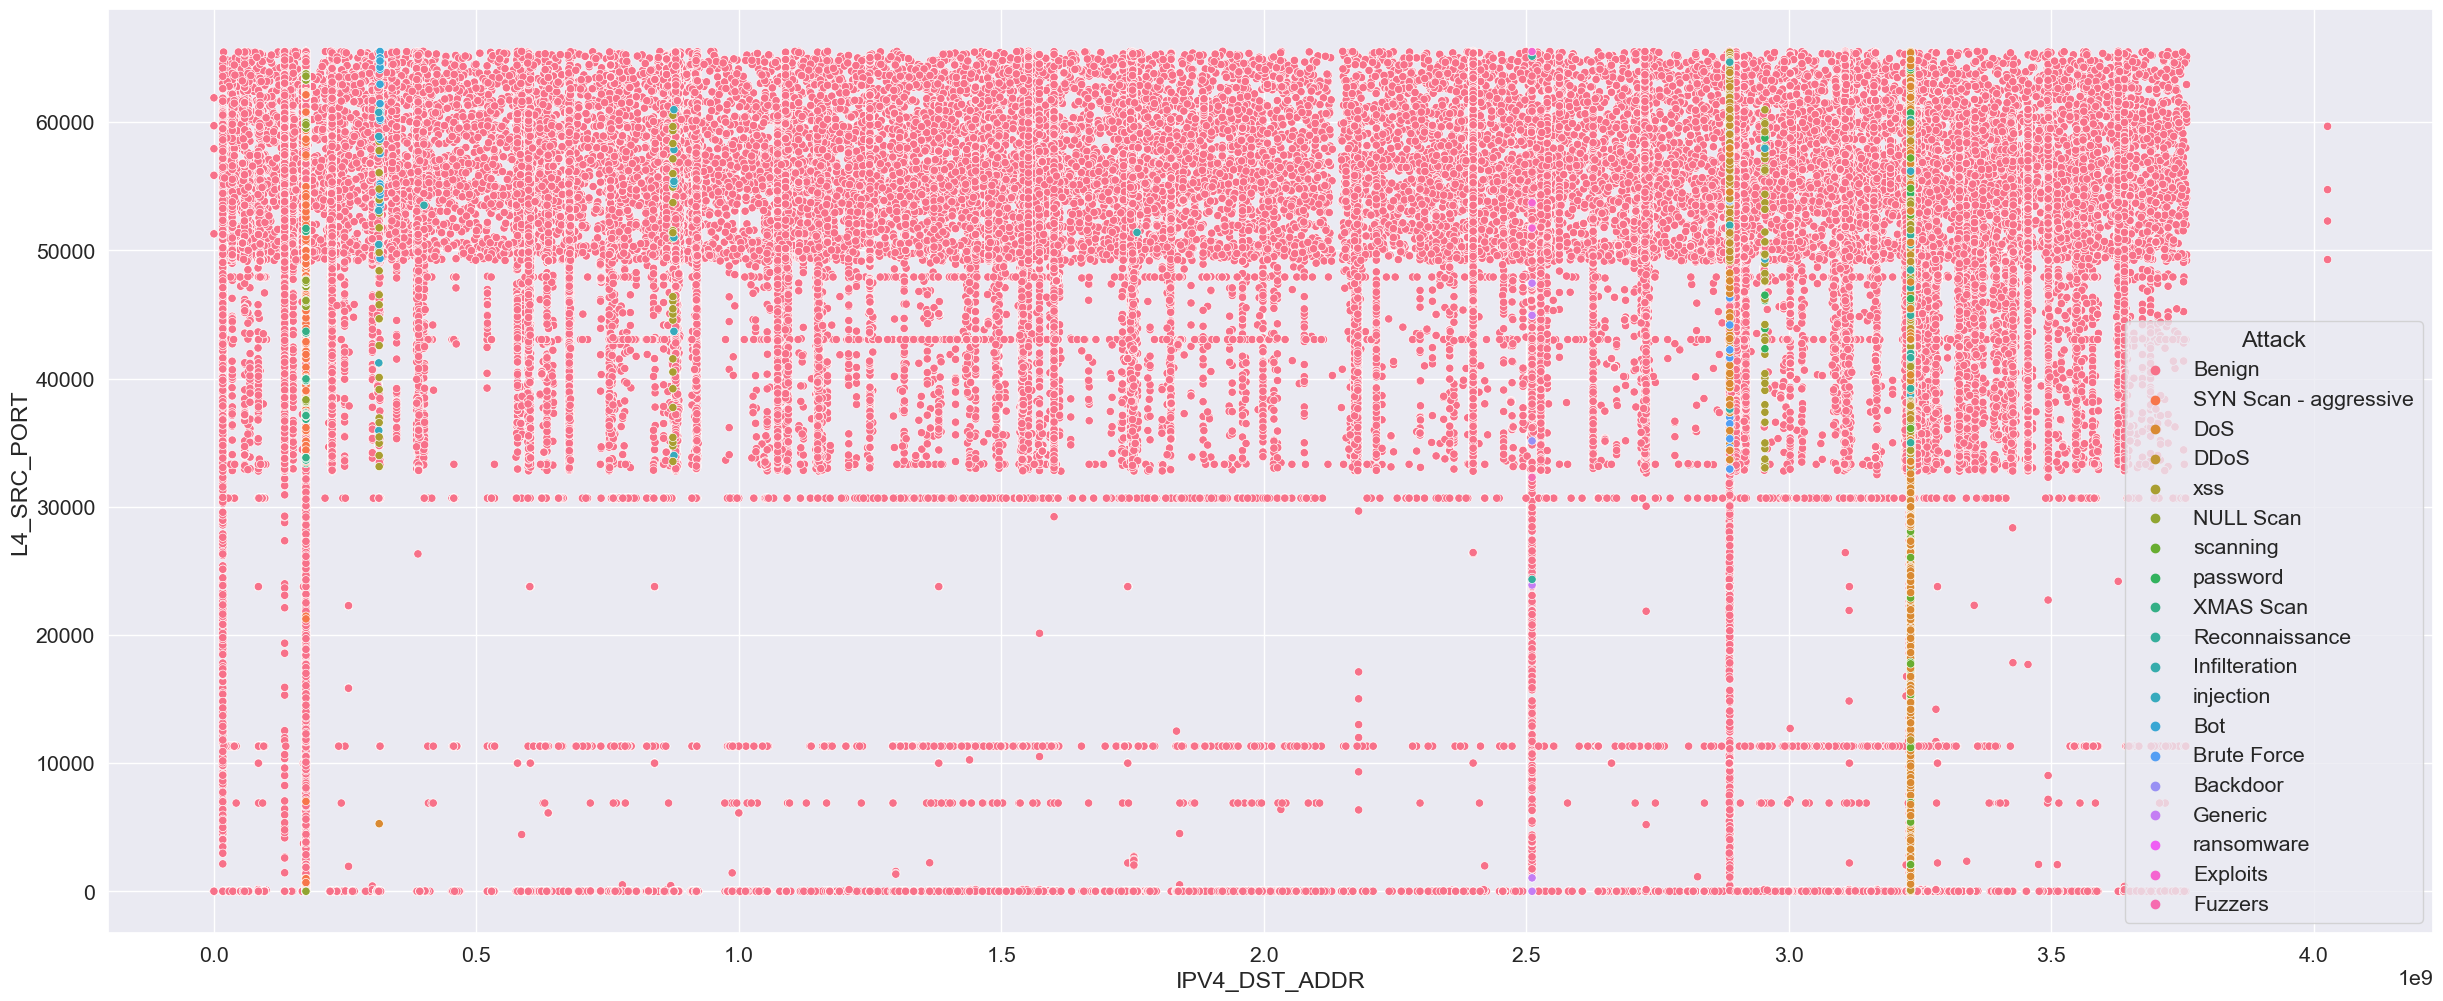

In [15]:
fig, ax = plt.subplots(figsize=(30, 12))
sns.scatterplot(data=df, x="IPV4_DST_ADDR", y="L4_SRC_PORT", hue="Attack", ax=ax)

<AxesSubplot:xlabel='L4_SRC_PORT', ylabel='L4_DST_PORT'>

/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ugu/Library/Python/3.7/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


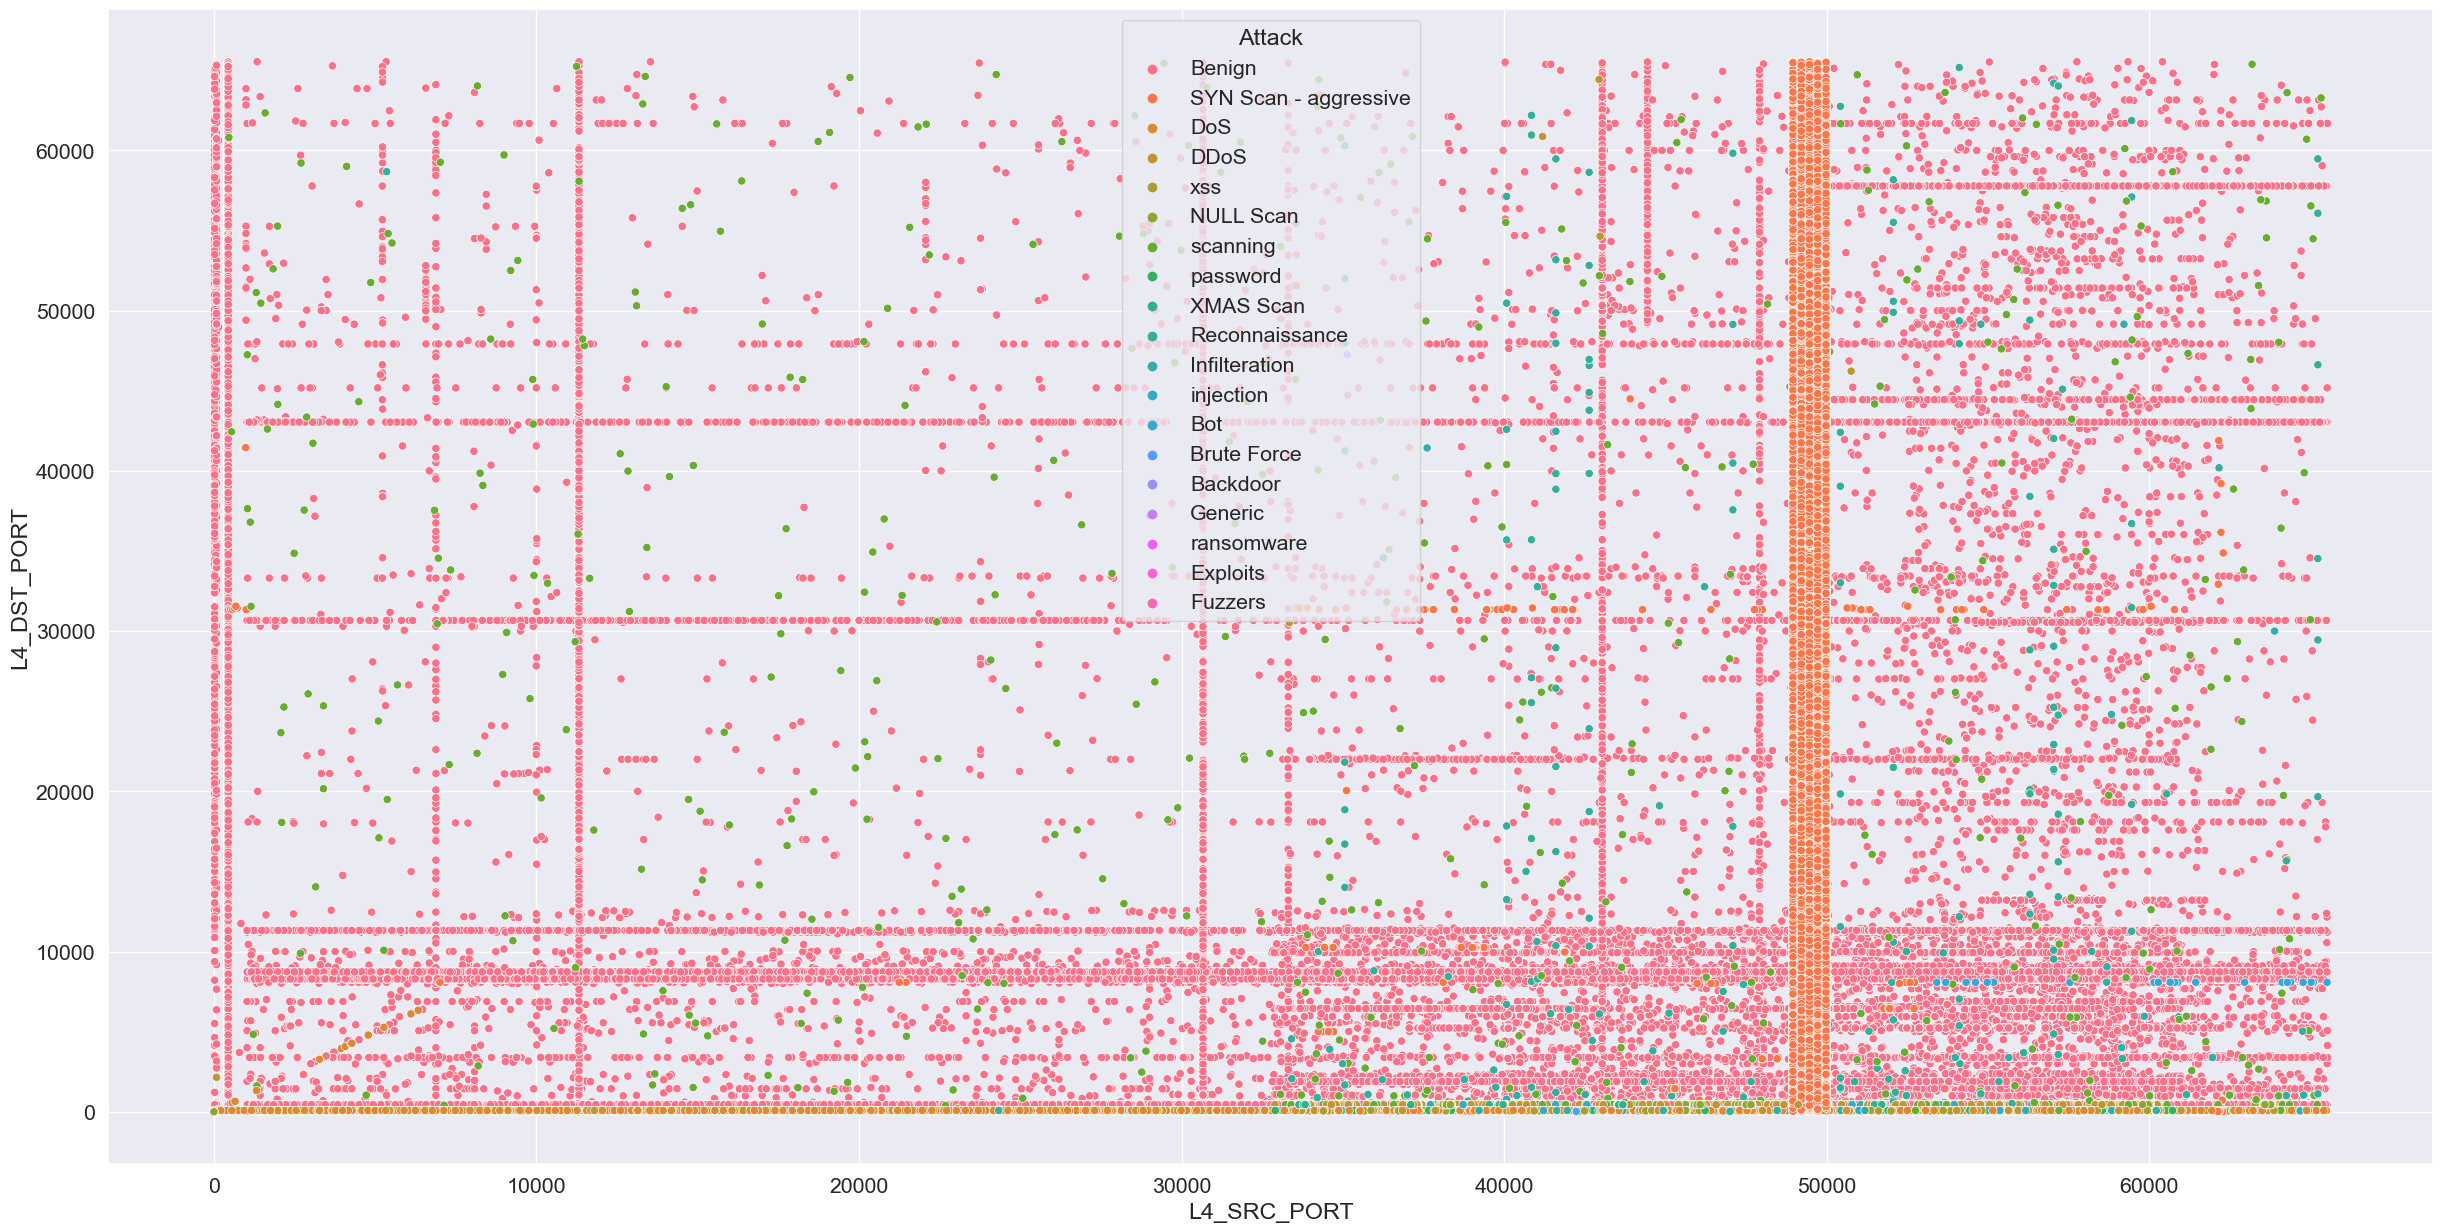

In [19]:
fig, ax = plt.subplots(figsize=(30, 15))
sns.scatterplot(data=df, x="L4_SRC_PORT", y="L4_DST_PORT", hue="Attack", ax=ax)

<AxesSubplot:xlabel='IN_BYTES', ylabel='OUT_BYTES'>

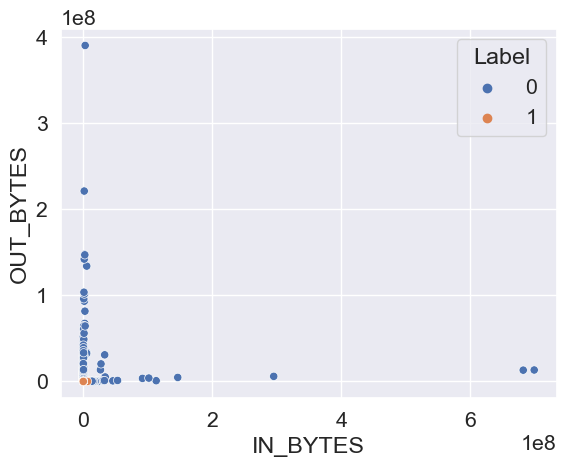

In [20]:
sns.scatterplot(data=df, x="IN_BYTES", y="OUT_BYTES", hue="Label")

In [24]:
df.PROTOCOL.describe()

count    597223.000000
mean          8.402314
std           4.843903
min           1.000000
25%           6.000000
50%           6.000000
75%           6.000000
max         177.000000
Name: PROTOCOL, dtype: float64

<AxesSubplot:xlabel='PROTOCOL', ylabel='Count'>

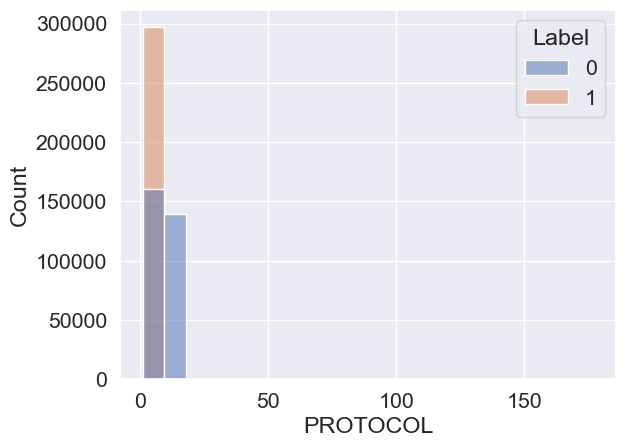

In [22]:
sns.histplot(data=df, x="PROTOCOL", hue="Label")

<AxesSubplot:xlabel='IN_BYTES', ylabel='Count'>

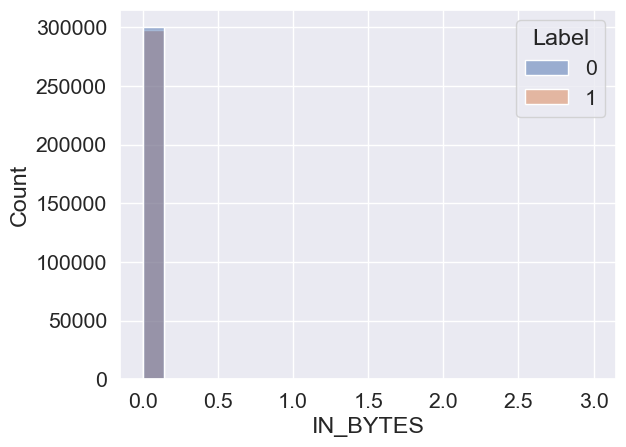

In [47]:
sns.histplot(data=df, x="IN_BYTES", hue="Label")

In [48]:
df.describe()

IPV4_SRC_ADDR   L4_SRC_PORT  IPV4_DST_ADDR    L4_DST_PORT  \
count   5.972230e+05  597223.00000   5.972230e+05  597223.000000   
mean    4.474240e+08   45191.38202   5.685460e+08   20011.162412   
std     7.668322e+08   15010.13529   9.211407e+08   21882.558325   
min     0.000000e+00       0.00000   0.000000e+00       0.000000   
25%     1.753009e+08   48616.00000   1.753006e+08      80.000000   
50%     1.753050e+08   49470.00000   1.753006e+08    9291.000000   
75%     1.753050e+08   49983.00000   1.753011e+08   39155.000000   
max     4.234391e+09   65534.00000   4.026532e+09   65535.000000   

            PROTOCOL       IN_BYTES        IN_PKTS      OUT_BYTES  \
count  597223.000000  597223.000000  597223.000000  597223.000000   
mean        8.402314       0.000012       0.000012       0.000018   
std         4.843903       0.005640       0.005640       0.005640   
min         1.000000       0.000000       0.000000       0.000000   
25%         6.000000       0.000000       0.000000       0.000000   
50%         6.000000       0.000000       0.000000       0.000000   
75%         6.000000       0.000000       0.000000       0.000000   
max       177.000000       3.000000       3.000000       3.000000   

            OUT_PKTS      TCP_FLAGS  FLOW_DURATION_MILLISECONDS  \
count  597223.000000  597223.000000               597223.000000   
mean        0.000022      14.056823                    0.017612   
std         0.005930      14.464179                    0.229182   
min         0.000000       0.000000                    0.000000   
25%         0.000000       0.000000                    0.000000   
50%         0.000000      22.000000                    0.000000   
75%         0.000000      22.000000                    0.000000   
max         3.000000     223.000000                    3.000000   

       MIN_IP_PKT_LEN  MAX_IP_PKT_LEN  RETRANSMITTED_IN_BYTES  \
count   597223.000000   597223.000000           597223.000000   
mean         0.011969        0.002806                0.000042   
std          0.131800        0.052995                0.008485   
min          0.000000        0.000000                0.000000   
25%          0.000000        0.000000                0.000000   
50%          0.000000        0.000000                0.000000   
75%          0.000000        0.000000                0.000000   
max          3.000000        3.000000                3.000000   

       RETRANSMITTED_IN_PKTS  RETRANSMITTED_OUT_BYTES  RETRANSMITTED_OUT_PKTS  \
count          597223.000000            597223.000000           597223.000000   
mean                0.000045                 0.000017                0.000017   
std                 0.008871                 0.006069                0.006069   
min                 0.000000                 0.000000                0.000000   
25%                 0.000000                 0.000000                0.000000   
50%                 0.000000                 0.000000                0.000000   
75%                 0.000000                 0.000000                0.000000   
max                 3.000000                 3.000000                3.000000   

       TCP_WIN_MAX_IN  TCP_WIN_MAX_OUT          Label  L7_PROTO_NAME  \
count   597223.000000    597223.000000  597223.000000  597223.000000   
mean         0.233352         0.155125       0.497702     263.086936   
std          0.764616         0.586387       0.499995     124.245653   
min          0.000000         0.000000       0.000000       0.000000   
25%          0.000000         0.000000       0.000000     175.000000   
50%          0.000000         0.000000       0.000000     348.000000   
75%          0.000000         0.000000       1.000000     348.000000   
max          3.000000         3.000000       1.000000     365.000000   

       DST_TO_SRC_SECOND_BYTES_MEAN  DST_TO_SRC_SECOND_BYTES_TOTAL  \
count                 597223.000000                  597223.000000   
mean                       0.000012                       0.000

### Outliers

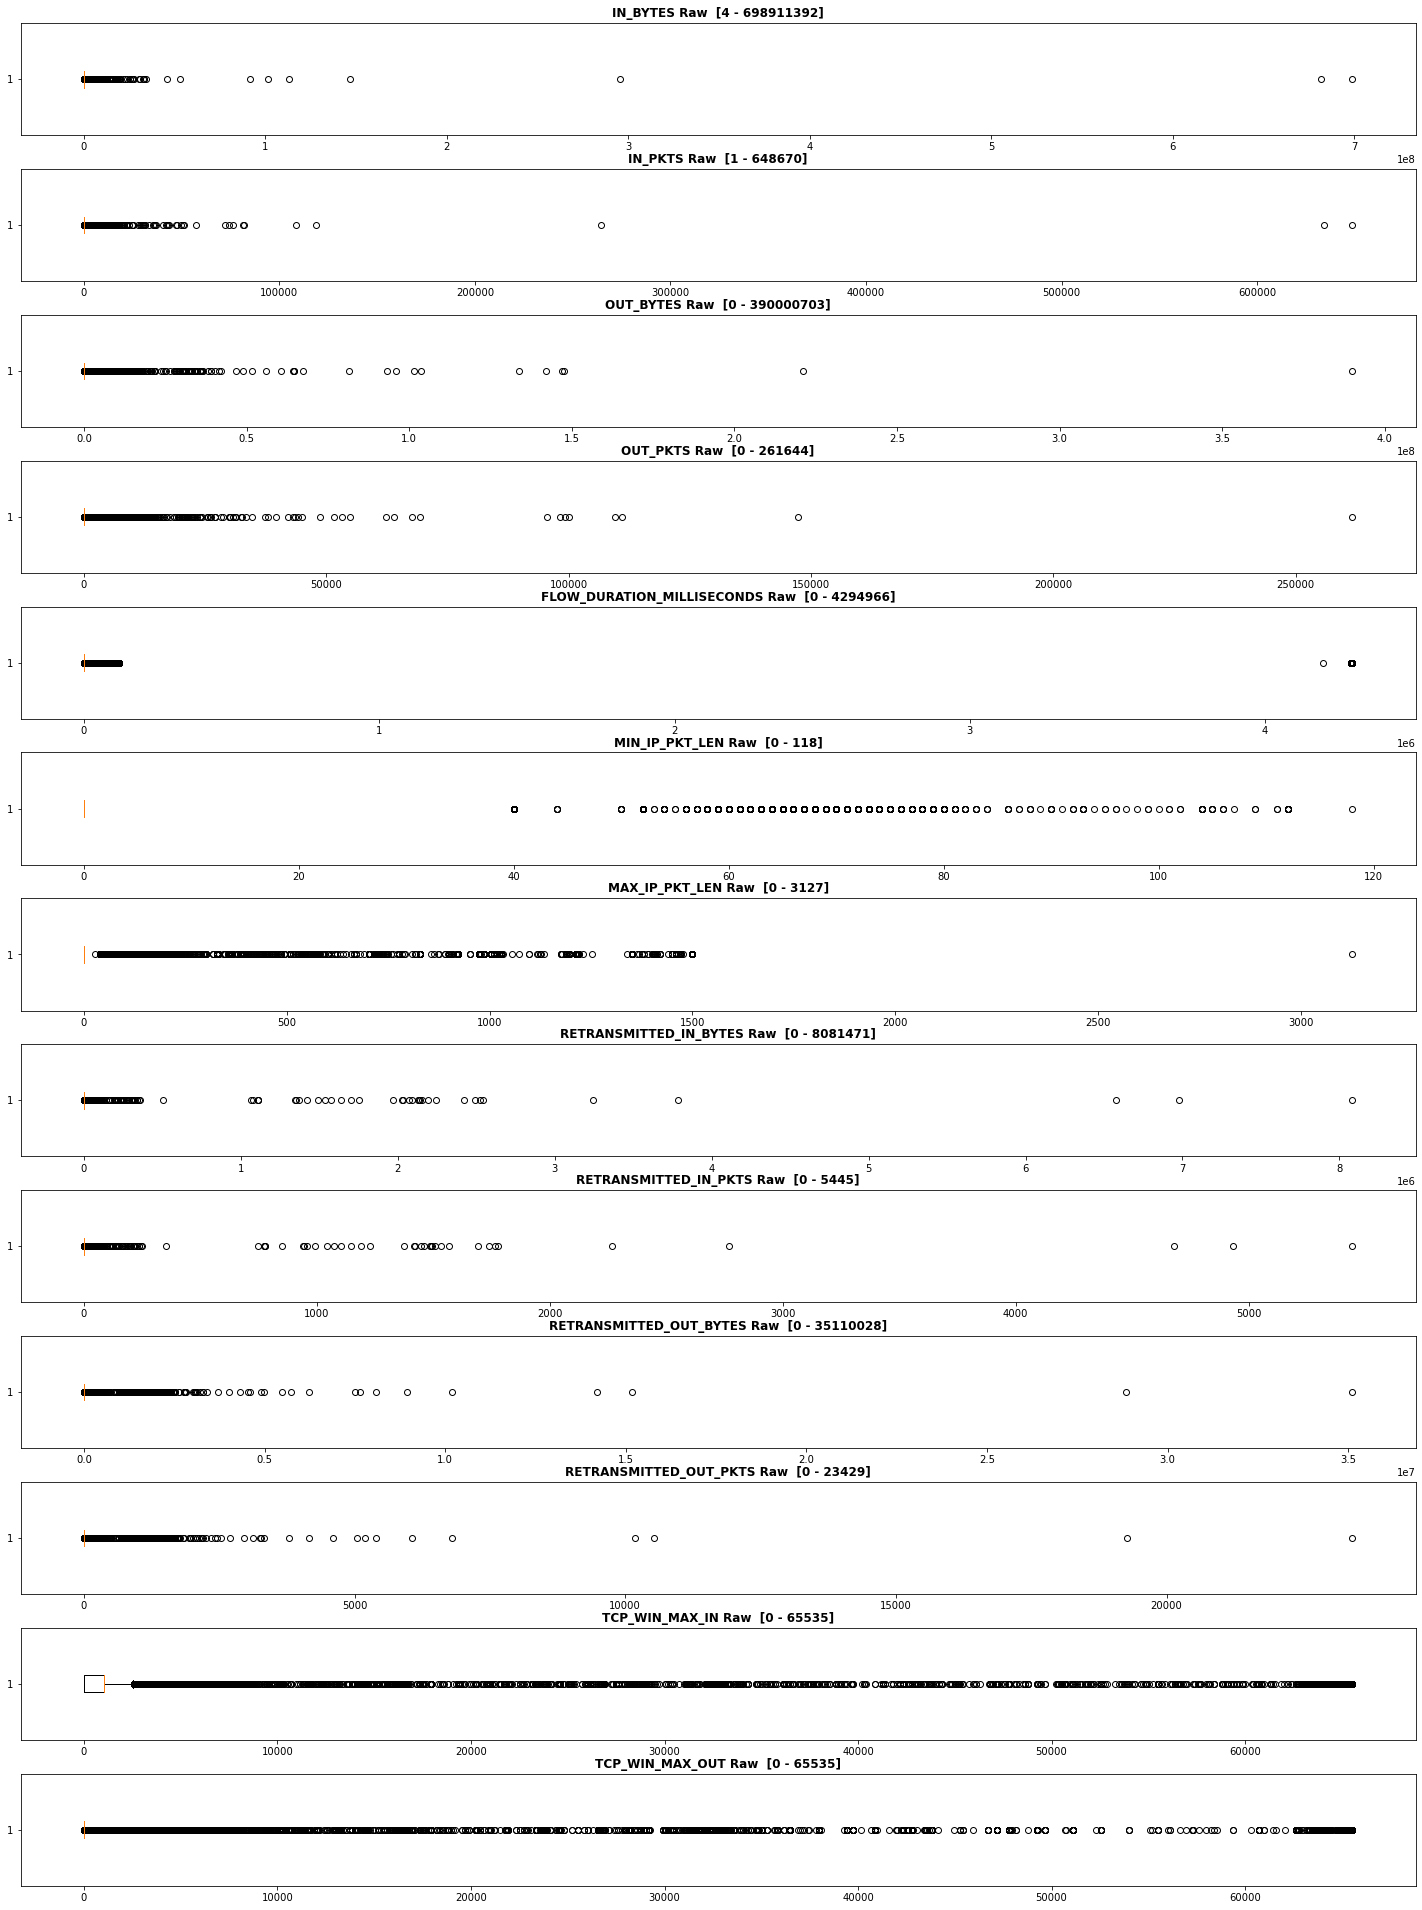

In [90]:
cols = ["IN_BYTES","IN_PKTS","OUT_BYTES","OUT_PKTS","FLOW_DURATION_MILLISECONDS","MIN_IP_PKT_LEN","MAX_IP_PKT_LEN","RETRANSMITTED_IN_BYTES","RETRANSMITTED_IN_PKTS","RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS","TCP_WIN_MAX_IN","TCP_WIN_MAX_OUT"]
fig_nr_columns = 1
fig_nr_rows = 17
fig = plt.figure(1, figsize=[25,45])

for k in range(len(cols)):
    num_bins = 100
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    ax = fig.add_subplot(fig_nr_rows, fig_nr_columns, k+1)
    yvalues = np.array(df[cols[k]].dropna())
    ax.boxplot(yvalues, vert=False)
    plt.title("{} Raw  [{} - {}]".format(cols[k], yvalues.min(), yvalues.max()), fontweight='bold')
plt.show()

In [148]:
# Piora a performance do modelo

out_cols = ["IN_BYTES","IN_PKTS","OUT_BYTES","OUT_PKTS","FLOW_DURATION_MILLISECONDS","MIN_IP_PKT_LEN","MAX_IP_PKT_LEN","RETRANSMITTED_IN_BYTES","RETRANSMITTED_IN_PKTS","RETRANSMITTED_OUT_BYTES","RETRANSMITTED_OUT_PKTS","TCP_WIN_MAX_IN","TCP_WIN_MAX_OUT"]

def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

def impute_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   upper = df[~(df>(q3+1.5*IQR))].max()
   lower = df[~(df<(q1-1.5*IQR))].min()

   df = np.where(df > upper,
       df.mean(),
       np.where(
           df < lower,
           df.mean(),
           df
           )
       )

   return df

df[out_cols] = impute_outliers_IQR(df[out_cols])



In [131]:
from sklearn.impute import SimpleImputer

def prepare_dataset(df):
    df_cpy = df.copy()

    # Handle IPs
    df_cpy.loc[:,'IPV4_SRC_ADDR'] = df_cpy['IPV4_SRC_ADDR'].copy().apply(ip2long)
    df_cpy.loc[:,'IPV4_DST_ADDR'] = df_cpy['IPV4_DST_ADDR'].copy().apply(ip2long)
    
    df_cpy['DST_TO_SRC_SECOND_BYTES_MEAN'] = df_cpy.DST_TO_SRC_SECOND_BYTES.apply(spb_to_mean)
    df_cpy['DST_TO_SRC_SECOND_BYTES_TOTAL'] = df_cpy.DST_TO_SRC_SECOND_BYTES.apply(spb_to_total)
    df_cpy['SRC_TO_DST_SECOND_BYTES_MEAN'] = df_cpy.SRC_TO_DST_SECOND_BYTES.apply(spb_to_mean)
    df_cpy['SRC_TO_DST_SECOND_BYTES_TOTAL'] = df_cpy.SRC_TO_DST_SECOND_BYTES.apply(spb_to_total)

    df_cpy = df_cpy.drop(['DST_TO_SRC_SECOND_BYTES', 'SRC_TO_DST_SECOND_BYTES', 'PROTOCOL_MAP'], axis=1)
    attack_encoder = LabelEncoder()
    df_cpy['AttackEnc'] = attack_encoder.fit_transform(df_cpy.Attack)
    
    l7_proto_encoder = LabelEncoder()
    df_cpy['L7_PROTO_NAME'] = l7_proto_encoder.fit_transform(df_cpy['L7_PROTO_NAME'])
    df_cpy = df_cpy[df_cpy['L7_PROTO_NAME'].notna()]
    """idx = df_cpy[df_cpy['PROTOCOL_MAP'] == ''].index
    df_cpy.loc[idx, 'PROTOCOL_MAP'] = 'tcp'

    oh_encoder = OneHotEncoder(sparse=False, handle_unknown='error')
    oh_encoding_columns = ['PROTOCOL_MAP']
    new_oh_encoding_columns = []

    for c in oh_encoding_columns:
        for v in df_cpy[c].unique():
            new_oh_encoding_columns.append(c[0] + '_' + str(v))

    # One-Hot Encoding
    oh_encoded_values = oh_encoder.fit_transform(df_cpy[oh_encoding_columns])
    oh_encoded_df = pd.DataFrame(oh_encoded_values, columns=new_oh_encoding_columns)
    df_cpy = df_cpy.join(oh_encoded_df)
    df_cpy.drop(oh_encoding_columns, axis=1, inplace=True)"""

    return df_cpy, attack_encoder, l7_proto_encoder
    
dataset, ae, l7pe = prepare_dataset(df)

In [73]:
print(len(dataset.columns))

384


In [65]:
dataset.head()

IPV4_SRC_ADDR  L4_SRC_PORT  IPV4_DST_ADDR  L4_DST_PORT  PROTOCOL  IN_BYTES  \
1      760179200            0      175300864            0         1        68   
2      175300608          443      175304960        24650         6       189   
5     2887729664        51860     1298005504          443         6       152   
6     3232235776        56402     3232235776         9012         6       232   
8     3288071936            0      175300608            0         1        32   

   IN_PKTS  OUT_BYTES  OUT_PKTS  TCP_FLAGS  FLOW_DURATION_MILLISECONDS  \
1        1          0         0          0                           0   
2        2        104         2         25                          44   
5        3        120         3        214                           0   
6        4        132         3         31                           0   
8        1          0         0          0                           0   

   MIN_IP_PKT_LEN  MAX_IP_PKT_LEN  RETRANSMITTED_IN_BYTES  \
1               0               0                       0   
2               0               0                       0   
5              40              52                       0   
6              40              92                       0   
8               0               0                       0   

   RETRANSMITTED_IN_PKTS  RETRANSMITTED_OUT_BYTES  RETRANSMITTED_OUT_PKTS  \
1                      0                        0                       0   
2                      0                        0                       0   
5                      0                        0                       0   
6                      0                        0                       0   
8                      0                        0                       0   

   TCP_WIN_MAX_IN  TCP_WIN_MAX_OUT  Label  Attack  \
1               0                0      0  Benign   
2             122             1634      0  Benign   
5            8192                0      0  Benign   
6           29200            65535      0  Benign   
8               0                0      0  Benign   

   DST_TO_SRC_SECOND_BYTES_MEAN  DST_TO_SRC_SECOND_BYTES_TOTAL  \
1                           0.0                            0.0   
2                         104.0                          104.0   
5                         120.0                          120.0   
6                         132.0                          132.0   
8                           0.0                            0.0   

   SRC_TO_DST_SECOND_BYTES_MEAN  SRC_TO_DST_SECOND_BYTES_TOTAL  AttackEnc  \
1                          68.0                           68.0          2   
2                         189.0                          189.0          2   
5                         152.0                          152.0          2   
6                         232.0                          232.0          2   
8                          32.0                           32.0          2   

   P_udp  P_tcp  P_icmp  P_gre   P_  P_ipv6-icmp  L_SIP  L_TLS  L_TLS.Google  \
1    0.0    0.0     0.0    0.0  1.0          0.0    0.0    0.0           0.0   
2    0.0    0.0     0.0    0.0  1.0          0.0    0.0    0.0           0.0   
5    0.0    0.0     1.0    0.0  0.0          0.0    0.0    0.0           0.0   
6    0.0    0.0     0.0    0.0  1.0          0.0    0.0    0.0           0.0   
8    0.0    0.0     0.0    0.0  0.0          1.0    0.0    0.0           0.0   

   L_ICMP.Amazon  L_DNS.Yahoo  L_DNS  L_DNS.Google  L_DNS.Microsoft  \
1            0.0          0.0    0.0           0.0              0.0   
2            0.0          0.0    0.0           0.0              0.0   
5            0.0          0.0    0.0           0.0              0.0   
6            0.0          0.0    0.0           0.0              0.0   
8            0.0          0.0    0.0           0.0              0.0   

   L_Unknown  L_NTP  L_BitTorrent  L_DNS.Facebook  L_ICMP  L_QUIC.Google  \
1        0.0    0.0           0.0             0.0     0.0            0.0   
2 

## Best features selection
### SelectKBest

In [138]:
kbest = SelectKBest(chi2, k=12)
X_new = kbest.fit_transform(dataset.drop(['Label', 'Attack', 'AttackEnc'], axis=1), dataset.Label)
kbest.get_feature_names_out()

array(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'IN_BYTES',
       'OUT_BYTES', 'FLOW_DURATION_MILLISECONDS', 'TCP_WIN_MAX_IN',
       'TCP_WIN_MAX_OUT', 'DST_TO_SRC_SECOND_BYTES_MEAN',
       'DST_TO_SRC_SECOND_BYTES_TOTAL', 'SRC_TO_DST_SECOND_BYTES_MEAN',
       'SRC_TO_DST_SECOND_BYTES_TOTAL'], dtype=object)

In [139]:
kbest = SelectKBest(chi2, k=12)
X_new = kbest.fit_transform(dataset.drop(['Label', 'Attack'], axis=1), dataset.AttackEnc)
kbest.get_feature_names_out()

array(['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'L4_DST_PORT', 'IN_BYTES',
       'OUT_BYTES', 'FLOW_DURATION_MILLISECONDS', 'TCP_WIN_MAX_IN',
       'TCP_WIN_MAX_OUT', 'DST_TO_SRC_SECOND_BYTES_MEAN',
       'DST_TO_SRC_SECOND_BYTES_TOTAL', 'SRC_TO_DST_SECOND_BYTES_MEAN',
       'SRC_TO_DST_SECOND_BYTES_TOTAL'], dtype=object)

### Feature importance
#### Label

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

nums = dataset.select_dtypes(include=np.number)

X = nums.drop(columns=['Label', 'AttackEnc'], axis=1)
y = nums.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

forest = RandomForestClassifier(random_state=2022)
forest.fit(X_train, y_train)

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=2022, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15, 7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

X = nums.drop(columns=['Label', 'AttackEnc'], axis=1)
y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

forest = RandomForestClassifier(random_state=2022)
forest.fit(X_train, y_train)

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=2022, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15, 7))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

### Model training
#### Full dataset - Label

In [87]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, mean_absolute_error

nums = df.select_dtypes(include=np.number)

X = nums.drop(columns=['Label', 'AttackEnc'], axis=1)
y = nums.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_full_label = RandomForestClassifier(random_state=2022)
model_full_label.fit(X_train, y_train)

full_label_train = f1_score(y_train, model_full_label.predict(X_train), average='macro')
full_label_test = f1_score(y_test, model_full_label.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", full_label_train)
print("TEST F1-SCORE:", full_label_test)

TRAIN F1-SCORE: 0.9999979069473792
TEST F1-SCORE: 0.9997404505890194


#### Full dataset - Attack

In [88]:
from sklearn.metrics import f1_score

nums = df.select_dtypes(include=np.number)

X = nums.drop(columns=['Label', 'AttackEnc'], axis=1)
y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_full_attack = RandomForestClassifier(random_state=2022)
model_full_attack.fit(X_train, y_train)

full_attack_train = f1_score(y_train, model_full_attack.predict(X_train), average='macro')
full_attack_test = f1_score(y_test, model_full_attack.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", full_attack_train)
print("TEST F1-SCORE:", full_attack_test)


TRAIN F1-SCORE: 0.9980320966380807
TEST F1-SCORE: 0.9119833145539044


#### 6 KBest features - Label

In [89]:
from sklearn.metrics import f1_score

nums = df.select_dtypes(include=np.number)

X = nums[['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'DST_TO_SRC_SECOND_BYTES_MEAN',
       'DST_TO_SRC_SECOND_BYTES_TOTAL', 'SRC_TO_DST_SECOND_BYTES_MEAN',
       'SRC_TO_DST_SECOND_BYTES_TOTAL']]
y = nums.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_6kbest_label = RandomForestClassifier(random_state=2022)
model_6kbest_label.fit(X_train, y_train)

kbest6_label_train = f1_score(y_train, model_6kbest_label.predict(X_train), average='macro')
kbest6_label_test = f1_score(y_test, model_6kbest_label.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", kbest6_label_train)
print("TEST F1-SCORE:", kbest6_label_test)


TRAIN F1-SCORE: 0.9998681376170515
TEST F1-SCORE: 0.999757195585411


#### 6 KBest Features - Attack

In [90]:
from sklearn.metrics import f1_score

nums = df.select_dtypes(include=np.number)

X = nums[['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'DST_TO_SRC_SECOND_BYTES_MEAN',
       'DST_TO_SRC_SECOND_BYTES_TOTAL', 'SRC_TO_DST_SECOND_BYTES_MEAN',
       'SRC_TO_DST_SECOND_BYTES_TOTAL']]
y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_6kbest_attack = RandomForestClassifier(random_state=2022)
model_6kbest_attack.fit(X_train, y_train)

kbest6_attack_train = f1_score(y_train, model_6kbest_attack.predict(X_train), average='macro')
kbest6_attack_test = f1_score(y_test, model_6kbest_attack.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", kbest6_attack_train)
print("TEST F1-SCORE:", kbest6_attack_test)


TRAIN F1-SCORE: 0.8789693397577176
TEST F1-SCORE: 0.7647069147363599


#### Best Feature importance - Label

In [46]:
from sklearn.metrics import f1_score

nums = dataset.select_dtypes(include=np.number)

X = nums[['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'TCP_WIN_MAX_IN']]
y = nums.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_feat_importance_label = RandomForestClassifier(random_state=2022)
model_feat_importance_label.fit(X_train, y_train)

feat_importance_label_train = f1_score(y_train, model_feat_importance_label.predict(X_train), average='macro')
feat_importance_label_test = f1_score(y_test, model_feat_importance_label.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", feat_importance_label_train)
print("TEST F1-SCORE:", feat_importance_label_test)


TRAIN F1-SCORE: 0.999987499998906
TEST F1-SCORE: 0.9996999995312492


#### Best Feature importance - Attack

In [45]:
from sklearn.metrics import f1_score

nums = dataset.select_dtypes(include=np.number)

X = nums[['IPV4_SRC_ADDR', 'IPV4_DST_ADDR', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'L7_PROTO_NAME']]
y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model_6kbest_attack = RandomForestClassifier(random_state=2022)
model_6kbest_attack.fit(X_train, y_train)

feat_importance_attack_train = f1_score(y_train, model_6kbest_attack.predict(X_train), average='macro')
feat_importance_attack_test = f1_score(y_test, model_6kbest_attack.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", feat_importance_attack_train)
print("TEST F1-SCORE:", feat_importance_attack_test)


TRAIN F1-SCORE: 0.941617746637494
TEST F1-SCORE: 0.6716282628823943


              type     score    set
0             full  0.999998  train
1             full  0.999740   test
2           kbest6  0.999868  train
3           kbest6  0.999757   test
4  feat_importance  0.999998  train
5  feat_importance  0.999816   test


<AxesSubplot:xlabel='type', ylabel='score'>

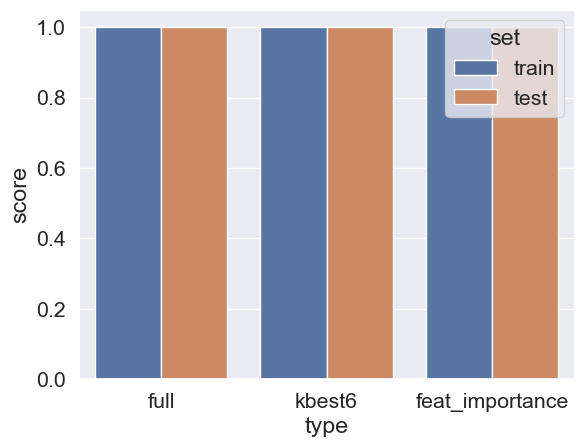

In [93]:
results_data_label = [
    { 'type': 'full', 'score': full_label_train, 'set': 'train' },
    { 'type': 'full', 'score': full_label_test, 'set': 'test' },
    { 'type': 'kbest6', 'score': kbest6_label_train, 'set': 'train' },
    { 'type': 'kbest6', 'score': kbest6_label_test, 'set': 'test' },
    { 'type': 'feat_importance', 'score': feat_importance_label_train, 'set': 'train' },
    { 'type': 'feat_importance', 'score': feat_importance_label_test, 'set': 'test' },
]

label_data = pd.DataFrame(results_data_label)
print(label_data)

sns.barplot(data=label_data, x="type", y="score", hue="set")

              type     score    set
0             full  0.998032  train
1             full  0.911983   test
2           kbest6  0.878969  train
3           kbest6  0.764707   test
4  feat_importance  0.995964  train
5  feat_importance  0.740533   test


<AxesSubplot:xlabel='type', ylabel='score'>

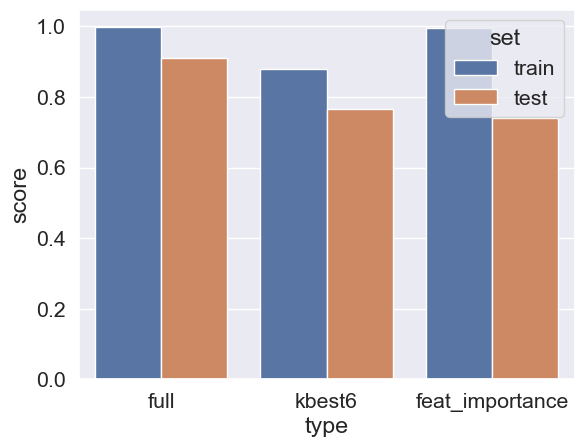

In [94]:
results_data_attack = [
    { 'type': 'full', 'score': full_attack_train, 'set': 'train' },
    { 'type': 'full', 'score': full_attack_test, 'set': 'test' },
    { 'type': 'kbest6', 'score': kbest6_attack_train, 'set': 'train' },
    { 'type': 'kbest6', 'score': kbest6_attack_test, 'set': 'test' },
    { 'type': 'feat_importance', 'score': feat_importance_attack_train, 'set': 'train' },
    { 'type': 'feat_importance', 'score': feat_importance_attack_test, 'set': 'test' },
]

attack_data = pd.DataFrame(results_data_attack)
print(attack_data)

sns.barplot(data=attack_data, x="type", y="score", hue="set")

In [101]:
forest_importances.index

Index(['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L4_DST_PORT', 'L4_SRC_PORT',
       'L7_PROTO_NAME', 'MAX_IP_PKT_LEN', 'TCP_WIN_MAX_IN',
       'FLOW_DURATION_MILLISECONDS', 'SRC_TO_DST_SECOND_BYTES_MEAN',
       'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'IN_BYTES',
       'TCP_FLAGS', 'DST_TO_SRC_SECOND_BYTES_TOTAL', 'IN_PKTS', 'OUT_BYTES',
       'OUT_PKTS', 'RETRANSMITTED_OUT_PKTS', 'RETRANSMITTED_IN_PKTS',
       'RETRANSMITTED_IN_BYTES', 'DST_TO_SRC_SECOND_BYTES_MEAN',
       'RETRANSMITTED_OUT_BYTES', 'MIN_IP_PKT_LEN', 'PROTOCOL'],
      dtype='object')

In [54]:
available_cols = list(forest_importances.index)
cols = []
data = []

for col in available_cols:
    cols.append(col)

    X = dataset[cols]
    y = dataset.AttackEnc
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

    model = RandomForestClassifier(random_state=2022)
    model.fit(X_train, y_train)

    score_train = f1_score(y_train, model.predict(X_train), average='macro')
    score_test = f1_score(y_test, model.predict(X_test), average='macro')
    cols_str = ','.join(cols)
    data.append({
        'n_cols': len(cols),
        'score': score_train,
        'set': 'train',
        'cols': cols_str
    })
    data.append({
        'n_cols':len(cols),
        'score': score_test,
        'set': 'test',
        'cols': cols_str
    })

    print(cols)
    print("TRAIN F1-SCORE:", score_train)
    print("TEST F1-SCORE:", score_test)
    print("\n")
    

['IPV4_DST_ADDR']
TRAIN F1-SCORE: 0.21128933741172248
TEST F1-SCORE: 0.25589832155210085


['IPV4_DST_ADDR', 'IPV4_SRC_ADDR']
TRAIN F1-SCORE: 0.28309504716475015
TEST F1-SCORE: 0.33783478734836836


['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L7_PROTO_NAME']
TRAIN F1-SCORE: 0.45630993310616647
TEST F1-SCORE: 0.4966611256465577


['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L7_PROTO_NAME', 'L4_SRC_PORT']
TRAIN F1-SCORE: 0.9342797062181173
TEST F1-SCORE: 0.6252064731692907


['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L7_PROTO_NAME', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN']
TRAIN F1-SCORE: 0.9363164569594347
TEST F1-SCORE: 0.658709028722607


['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L7_PROTO_NAME', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT']
TRAIN F1-SCORE: 0.9363166687116348
TEST F1-SCORE: 0.6452312975158673


['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L7_PROTO_NAME', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'TCP_WIN_MAX_IN']
TRAIN F1-SCORE: 0.9731958261363449
TEST F1-SCORE: 0.6661637688868295


['IPV4_DST_ADDR', 'IPV4_

<AxesSubplot:xlabel='n_cols', ylabel='score'>

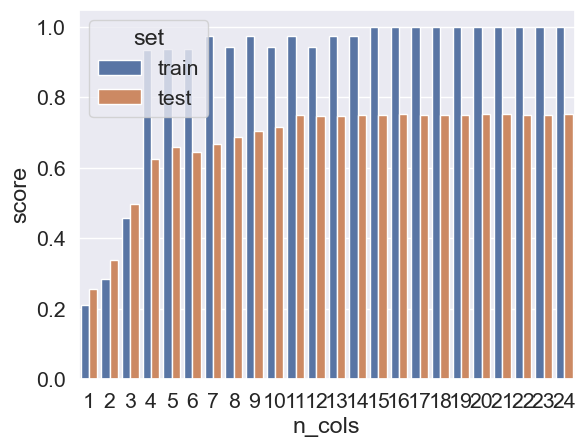

In [55]:
data_pd = pd.DataFrame(data)
sns.barplot(data=data_pd, x="n_cols", y="score", hue="set")

In [115]:
data_pd[data_pd.n_cols == 7].cols.values


array(['IPV4_DST_ADDR,IPV4_SRC_ADDR,L4_DST_PORT,L4_SRC_PORT,L7_PROTO_NAME,MAX_IP_PKT_LEN,TCP_WIN_MAX_IN',
       'IPV4_DST_ADDR,IPV4_SRC_ADDR,L4_DST_PORT,L4_SRC_PORT,L7_PROTO_NAME,MAX_IP_PKT_LEN,TCP_WIN_MAX_IN'],
      dtype=object)

In [114]:
data_pd[data_pd.n_cols == 14].cols.values

array(['IPV4_DST_ADDR,IPV4_SRC_ADDR,L4_DST_PORT,L4_SRC_PORT,L7_PROTO_NAME,MAX_IP_PKT_LEN,TCP_WIN_MAX_IN,FLOW_DURATION_MILLISECONDS,SRC_TO_DST_SECOND_BYTES_MEAN,TCP_WIN_MAX_OUT,SRC_TO_DST_SECOND_BYTES_TOTAL,IN_BYTES,TCP_FLAGS,DST_TO_SRC_SECOND_BYTES_TOTAL',
       'IPV4_DST_ADDR,IPV4_SRC_ADDR,L4_DST_PORT,L4_SRC_PORT,L7_PROTO_NAME,MAX_IP_PKT_LEN,TCP_WIN_MAX_IN,FLOW_DURATION_MILLISECONDS,SRC_TO_DST_SECOND_BYTES_MEAN,TCP_WIN_MAX_OUT,SRC_TO_DST_SECOND_BYTES_TOTAL,IN_BYTES,TCP_FLAGS,DST_TO_SRC_SECOND_BYTES_TOTAL'],
      dtype=object)

In [117]:
cols

['IPV4_DST_ADDR',
 'IPV4_SRC_ADDR',
 'L4_DST_PORT',
 'L4_SRC_PORT',
 'L7_PROTO_NAME',
 'MAX_IP_PKT_LEN',
 'FLOW_DURATION_MILLISECONDS',
 'SRC_TO_DST_SECOND_BYTES_MEAN',
 'TCP_WIN_MAX_OUT',
 'SRC_TO_DST_SECOND_BYTES_TOTAL',
 'IN_BYTES',
 'TCP_FLAGS',
 'DST_TO_SRC_SECOND_BYTES_TOTAL']

In [145]:
from sklearn.metrics import f1_score

nums = dataset.select_dtypes(include=np.number)

#cols = ['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L7_PROTO_NAME', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'TCP_WIN_MAX_IN', 'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN', 'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES_MEAN', 'IN_BYTES', 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'IN_PKTS', 'PROTOCOL', 'TCP_FLAGS', 'RETRANSMITTED_IN_BYTES']
cols = ['IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L7_PROTO_NAME', 'L4_SRC_PORT', 'MAX_IP_PKT_LEN', 'L4_DST_PORT', 'TCP_WIN_MAX_IN', 'FLOW_DURATION_MILLISECONDS', 'MIN_IP_PKT_LEN', 'TCP_WIN_MAX_OUT', 'SRC_TO_DST_SECOND_BYTES_MEAN', 'IN_BYTES', 'SRC_TO_DST_SECOND_BYTES_TOTAL', 'IN_PKTS', 'PROTOCOL', 'TCP_FLAGS']

X = nums[cols]
y = nums.AttackEnc
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

model = RandomForestClassifier(random_state=2022)
model.fit(X_train, y_train)

score_train = f1_score(y_train, model.predict(X_train), average='macro')
score_test = f1_score(y_test, model.predict(X_test), average='macro')

print("TRAIN F1-SCORE:", score_train)
print("TEST F1-SCORE:", score_test)
cols

TRAIN F1-SCORE: 0.9983459002143877
TEST F1-SCORE: 0.7533269684921228


['IPV4_DST_ADDR',
 'IPV4_SRC_ADDR',
 'L7_PROTO_NAME',
 'L4_SRC_PORT',
 'MAX_IP_PKT_LEN',
 'L4_DST_PORT',
 'TCP_WIN_MAX_IN',
 'FLOW_DURATION_MILLISECONDS',
 'MIN_IP_PKT_LEN',
 'TCP_WIN_MAX_OUT',
 'SRC_TO_DST_SECOND_BYTES_MEAN',
 'IN_BYTES',
 'SRC_TO_DST_SECOND_BYTES_TOTAL',
 'IN_PKTS',
 'PROTOCOL',
 'TCP_FLAGS']

In [147]:
model = RandomForestClassifier(random_state=2022)
model.fit(X, y)

RandomForestClassifier(random_state=2022)

In [148]:
import pickle

filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))
filename = 'attack_encoder.sav'
pickle.dump(ae, open(filename, 'wb'))
filename = 'l7_pn.sav'
pickle.dump(l7pe, open(filename, 'wb'))
pickle.dump(cols, open(filename, 'wb'))